# Introduction
Welcome to ​​Alex Jiang, Zhiqi Cui and Xiaoyu Liu's CIS 545 final project from Fall 2021.

For the background,
with more age groups being eligible for booster shots, it is important to know what percent of the population would be willing to get the boosters. Efficacy of the prior two doses is also wearing off for most people, so we think that it is a good idea to revisit COVID-19 predictions, especially right now with the rise of COVID cases (again) in pockets of the Northeast, Midwest, and southwest. In most other regions cases have been stable, but they have not substantially decreased. With the onset of winter, this could change at moment’s notice.
In addition, many datasets only look for 1 or 2 or maybe at most 3 things such as vaccination rate to cases or race to vaccination rate or location to race to vaccination rate. We seek to take a more holistic approach since just saying x race has a lower vaccination rate does not paint the whole picture. We want to look at other factors that might affect a person’s decision beside their race or location. For example, education level and overall hesitancy to receive the vaccine might be more important. 

Throughout this notebook we'll be trying to predict COVID-19 outcomes and help provide some direction to policy makers in the event of rising cases or vaccine efficacy wearing off by seeing how all these data points correlate to each other. And in this notebook we will show you the entire process as downloading and acquiring preliminary datasets, extracting features, conducting EDA, and constructing models.


## Download & Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandasql
!pip install geopandas 
!pip install mapclassify
!pip install squarify
!nvidia-smi

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=7613914dfed3d876720c61283ac388361bb9ef35fde8fac248a85e26141de045
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 290 kB/s 
     |████████████████████████████████| 6.3 MB 27.0 MB/s 
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import os
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
import geopandas 
from shapely.geometry import LineString,Point
import squarify
import warnings

warnings.filterwarnings("ignore")
pysqldf = lambda q: sqldf(q, globals())

## Download Data
The datasets used in our project include:  
*   Vaccine Hesitancy Data
*   US Census Data
*   JHU COVID-19 Data
*   JHU Vaccination Data
*   USDA Education Level Data
*   USDA Unemployment Data
*   USDA Poverty Data

Note that these data are downloaded directly from servers as in the following cells. 

In [ ]:
#https://drive.google.com/file/d/1nU_TenkBkjaHyRppwTQBGd7XL9neMcNn/view?usp=sharing
census_data_file_id = "1nU_TenkBkjaHyRppwTQBGd7XL9neMcNn"
census_data_dest_path = "/content/cc-est2019-alldata.csv"
gdd.download_file_from_google_drive(file_id = census_data_file_id,
                                    dest_path = census_data_dest_path)

In [ ]:
#https://drive.google.com/file/d/1I58WpmCMvYswzMF5Iqutz1W30SRnHE8p/view?usp=sharing
vaccine_hesitancy_data_file_id = "1I58WpmCMvYswzMF5Iqutz1W30SRnHE8p"
vaccine_hesitancy_data_dest_path = "/content/vaccine-hesitancy.csv"
gdd.download_file_from_google_drive(file_id = vaccine_hesitancy_data_file_id,
                                    dest_path = vaccine_hesitancy_data_dest_path)

# Data Extraction & Cleaning

## JHU COVID-19 Data

In this section we will do the following things:

*   Mount the original dataset to drive and set up authentication protocols.
*   preprocessing covid_19_daily_reports: load all daily dataset and concat into a total csv which contains all dates.
*   Save as a total csv file. 

In [ ]:
# Preprocessing covid_19_daily_reports (one-time use only)

# load all daily dataset and concate into a total csv which contains all dates.
# !unzip /content/drive/MyDrive/csse_covid_19_daily_reports.zip
# path = '/content/csse_covid_19_daily_reports'   
# files = os.listdir(path)  

# df1 = pd.read_csv(path + '/' + files[0],encoding='gbk')  

# for file in files[1:]:
#   df2 = pd.read_csv(path +'/' +  file,encoding='gbk') 
#   df1 = pd.concat([df1,df2],axis=0,ignore_index=True)  

# df1 = df1.drop_duplicates() 
# df1 = df1.reset_index(drop=True) 
# df1.to_csv(path + '/' + 'total.csv') 

In [ ]:
#Upload the dataset into google file and download the dataset to colab
#https://drive.google.com/file/d/1AyJVAuEAzHsvFfKdbF8_Eb9O3SLum0-b/view?usp=sharing

df_jhu_covid_id = "1AyJVAuEAzHsvFfKdbF8_Eb9O3SLum0-b"
df_jhu_covid_path = "/content/total.csv"
gdd.download_file_from_google_drive(file_id = df_jhu_covid_id,
                                    dest_path = df_jhu_covid_path)

In [ ]:
df_jhu_covid = pd.read_csv('/content/total.csv',error_bad_lines=False)
df_jhu_covid

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Province/State,Country/Region,Last Update,Incidence_Rate,Case-Fatality_Ratio,Latitude,Longitude,.DS_Store
0,0,NaN,NaN,NaN,Afghanistan,2021-05-05 04:20:43,33.939110,67.709953,60563.0,2648.0,53694.0,4221.0,Afghanistan,155.575600,4.372307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,Albania,2021-05-05 04:20:43,41.153300,20.168300,131327.0,2402.0,112626.0,16299.0,Albania,4563.451247,1.829022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,Algeria,2021-05-05 04:20:43,28.033900,1.659600,122999.0,3289.0,85693.0,34017.0,Algeria,280.492758,2.674005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,Andorra,2021-05-05 04:20:43,42.506300,1.521800,13316.0,127.0,12818.0,371.0,Andorra,17234.194008,0.953740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,Angola,2021-05-05 04:20:43,-11.202700,17.873900,27284.0,609.0,24190.0,2485.0,Angola,83.015206,2.232077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384724,2384724,NaN,NaN,NaN,West Bank and Gaza,2021-10-05 04:21:27,31.952200,35.233200,408211.0,4156.0,NaN,NaN,West Bank and Gaza,8001.915547,1.018101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384725,2384725,NaN,NaN,NaN,Yemen,2021-10-05 04:21:27,15.552727,48.516388,9214.0,1743.0,NaN,NaN,Yemen,30.892543,18.916866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384726,2384726,NaN,NaN,NaN,Zambia,2021-10-05 04:21:27,-13.133897,27.849332,209172.0,3649.0,NaN,NaN,Zambia,1137.796457,1.744497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384727,2384727,NaN,NaN,NaN,Zimbabwe,2021-10-05 04:21:27,-19.015438,29.154857,131129.0,4627.0,NaN,NaN,Zimbabwe,882.255561,3.528586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, let's rename some columns select the columns which are related to our predict task and delete some NaN columns to clean the Covid dataframe for our further analysis.
And we set the time period from 3/1/2021 to 11/15/2021.

In [ ]:
# filter data from 2021/3/1 to 2021/11/15
import time
df_jhu_covid_us= df_jhu_covid[df_jhu_covid['Country_Region']=='US']
df_jhu_covid_us_date=df_jhu_covid_us[(df_jhu_covid_us['Last_Update']>='2021-03-01')&(df_jhu_covid_us['Last_Update']<='2021-11-15')]
del df_jhu_covid_us_date['Latitude']
del df_jhu_covid_us_date['Longitude']
df_jhu_covid_us_date.rename(columns={'Last_Update':'date'},inplace=True)
df_jhu_covid_us_date.rename(columns={'Admin2':'County_Name'},inplace=True)
df_jhu_covid_us_date.rename(columns={'FIPS':'FIPS Code'},inplace=True)
df_jhu_covid_us_date.rename(columns={'Lat':'Latitude'},inplace=True)
df_jhu_covid_us_date.rename(columns={'Long_':'Longitude'},inplace=True)
df_jhu_covid_us_date['date']=pd.to_datetime(df_jhu_covid_us_date['date'])
df_jhu_covid_us_date['date']=df_jhu_covid_us_date['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
df_jhu_covid_us_date['date']=pd.to_datetime(df_jhu_covid_us_date['date'])
df_jhu_covid_us_date=df_jhu_covid_us_date[['FIPS Code','County_Name','Province_State','Latitude','Longitude','date','Confirmed','Deaths','Combined_Key','Incident_Rate','Case_Fatality_Ratio']]
df_jhu_covid_us_date

,FIPS Code,County_Name,Province_State,Latitude,Longitude,date,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio
651,1001.0,Autauga,Alabama,32.539527,-86.644082,2021-05-05,6910.0,107.0,"Autauga, Alabama, US",12368.218511,1.548480
652,1003.0,Baldwin,Alabama,30.727750,-87.722071,2021-05-05,20993.0,306.0,"Baldwin, Alabama, US",9404.033436,1.457629
653,1005.0,Barbour,Alabama,31.868263,-85.387129,2021-05-05,2302.0,56.0,"Barbour, Alabama, US",9325.123552,2.432667
654,1007.0,Bibb,Alabama,32.996421,-87.125115,2021-05-05,2597.0,63.0,"Bibb, Alabama, US",11596.856301,2.425876
655,1009.0,Blount,Alabama,33.982109,-86.567906,2021-05-05,6621.0,135.0,"Blount, Alabama, US",11449.866842,2.038967
...,...,...,...,...,...,...,...,...,...,...,...
2384669,56039.0,Teton,Wyoming,43.935225,-110.589080,2021-10-05,4953.0,13.0,"Teton, Wyoming, US",21108.932833,0.262467
2384670,56041.0,Uinta,Wyoming,41.287818,-110.547578,2021-10-05,3578.0,25.0,"Uinta, Wyoming, US",17690.101849,0.698714
2384671,90056.0,Unassigned,Wyoming,NaN,NaN,2021-10-05,0.0,0.0,"Unassigned, Wyoming, US",NaN,NaN
2384672,56043.0,Washakie,Wyoming,43.904516,-107.680187,2021-10-05,1422.0,27.0,"Washakie, Wyoming, US",18219.090327,1.898734


The section below cleans the JHU COVID-19 Data Cleaning by dropping NaN values.

In [ ]:
check=df_jhu_covid_us_date.groupby(['date']).count().reset_index()
check[check['County_Name']<3201]

,date,FIPS Code,County_Name,Province_State,Latitude,Longitude,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio
93,2021-06-02,3166,3173,3177,3114,3114,3177,3177,3177,3114,3147
104,2021-06-13,3191,3198,3202,3140,3140,3202,3202,3202,3140,3172
128,2021-07-07,3165,3172,3176,3114,3114,3176,3176,3176,3114,3147


In [ ]:
# About the missing part from the dataframe
# first look at the general situation
print(df_jhu_covid_us_date.isnull().sum())
#print out the null rows to find the method of processing them
miss_l=df_jhu_covid_us_date[df_jhu_covid_us_date['Latitude'].isnull()]
print(miss_l)

# group by FIPS Code to see the scale of missing data
Num_County=len(df_jhu_covid_us_date.groupby(['FIPS Code']).count())
Num_missl_County=len(miss_l.groupby(['FIPS Code']).count().reset_index())
print(Num_missl_County/Num_County) #0.01870591842992947

FIPS Code               2849
County_Name             1075
Province_State             0
Latitude               16153
Longitude              16153
date                       0
Confirmed                  0
Deaths                     0
Combined_Key               0
Incident_Rate          16412
Case_Fatality_Ratio     7507
dtype: int64
         FIPS Code County_Name  ... Incident_Rate  Case_Fatality_Ratio
746        90002.0  Unassigned  ...           NaN             0.000000
761        80004.0   Out of AZ  ...           NaN                  NaN
765        90004.0  Unassigned  ...           NaN                  NaN
837        90005.0  Unassigned  ...           NaN             0.000000
899        90006.0  Unassigned  ...           NaN             0.000000
...            ...         ...  ...           ...                  ...
2384329    90049.0  Unassigned  ...           NaN             0.220588
2384344    90050.0  Unassigned  ...           NaN             0.000000
2384516    90053.0  Unassigne

It is okay to drop the rows with either null in Latitude and Longitude or County_Name

In [ ]:
df_jhu_covid_us_date=df_jhu_covid_us_date[~df_jhu_covid_us_date['Latitude'].isnull()]
df_jhu_covid_us_date=df_jhu_covid_us_date[~df_jhu_covid_us_date['County_Name'].isnull()]

In [ ]:
# Compare the same state with other tables to see how to handle with null in FIPS Code
# Here we compared the same state e.g."Utah"
df_jhu_covid_us_date[(df_jhu_covid_us_date['Province_State']=='Utah')&(df_jhu_covid_us_date['FIPS Code'].isnull())]


,FIPS Code,County_Name,Province_State,Latitude,Longitude,date,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio
3571,NaN,Bear River,Utah,41.521068,-113.083282,2021-05-05,21522.0,100.0,"Bear River, Utah, US",11520.303183,0.464641
3572,NaN,Central Utah,Utah,39.372319,-111.575868,2021-05-05,8868.0,65.0,"Central Utah, Utah, US",10820.704298,0.732972
3576,NaN,Southeast Utah,Utah,38.996171,-110.701396,2021-05-05,3474.0,27.0,"Southeast Utah, Utah, US",8635.561411,0.777202
3577,NaN,Southwest Utah,Utah,37.854472,-111.441876,2021-05-05,28729.0,266.0,"Southwest Utah, Utah, US",11398.497076,0.925894
3580,NaN,TriCounty,Utah,40.124915,-109.517442,2021-05-05,4012.0,36.0,"TriCounty, Utah, US",7085.585108,0.897308
...,...,...,...,...,...,...,...,...,...,...,...
2384320,NaN,Central Utah,Utah,39.372319,-111.575868,2021-10-05,12662.0,97.0,"Central Utah, Utah, US",15450.130561,0.766072
2384324,NaN,Southeast Utah,Utah,38.996171,-110.701396,2021-10-05,5176.0,38.0,"Southeast Utah, Utah, US",12866.340202,0.734158
2384325,NaN,Southwest Utah,Utah,37.854472,-111.441876,2021-10-05,38585.0,360.0,"Southwest Utah, Utah, US",15308.956444,0.933005
2384328,NaN,TriCounty,Utah,40.124915,-109.517442,2021-10-05,7523.0,58.0,"TriCounty, Utah, US",13286.355127,0.770969


In [ ]:
print(df_jhu_covid_us_date.isnull().sum())

FIPS Code              2072
County_Name               0
Province_State            0
Latitude                  0
Longitude                 0
date                      0
Confirmed                 0
Deaths                    0
Combined_Key              0
Incident_Rate           259
Case_Fatality_Ratio     744
dtype: int64


## US Census Data

In [ ]:
census_df = pd.read_csv('/content/cc-est2019-alldata.csv', encoding='latin-1')
census_df

,,"<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv=""content-type"" content=""text/html; charset=utf-8""/><style nonce=""JdcfBlp+ijzrGp0VunbWeA"">/* Copyright 2022 Google Inc. All Rights Reserved. */"
.goog-inline-block{position:relative;display:-moz-inline-box;display:inline-block}* html .goog-inline-block{display:inline}*:first-child+html .goog-inline-block{display:inline}.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial,sans-serif;margin:0}.grecaptcha-badge{visibility:hidden}.uc-main{padding-top:50px;text-align:center}#uc-dl-icon{display:inline-block;margin-top:16px;padding-right:1em;vertical-align:top}#uc-text{display:inline-block;max-width:68ex;text-align:left}.uc-error-caption,.uc-warning-caption{color:#222;font-size:16px}...


In [ ]:
# filter data
# take data from year 12 aka the most recent (2019) result year from the data
filtered_census_df = census_df[census_df["YEAR"] == 12]
# only take the columns that we need for our analytics
filtered_census_df = filtered_census_df[["STNAME", "CTYNAME", "AGEGRP", "TOT_POP", "TOT_MALE", "TOT_FEMALE"]]
# calculate average age for each county
ageGrpToAge = {1:2, 2:7, 3:12, 4:17, 5:22, 6:27, 7:32, 8:37, 9:42, 10:47, 11:52, 12:57, 13:62, 14:67, 15:72, 16:77, 17:82, 18:88}

temp_df = filtered_census_df[filtered_census_df.AGEGRP != 0]
temp_df["TOT_AGE"] = temp_df.apply(lambda x: x.TOT_POP * ageGrpToAge[x.AGEGRP], axis = 1)
temp_df["TOT_MALE_AGE"] = temp_df.apply(lambda x: x.TOT_MALE * ageGrpToAge[x.AGEGRP], axis = 1)
temp_df["TOT_FEMALE_AGE"] = temp_df.apply(lambda x: x.TOT_FEMALE * ageGrpToAge[x.AGEGRP], axis = 1)

median_query = """SELECT STNAME, CTYNAME, 
                  (SUM(TOT_AGE) / SUM(TOT_POP)) AS AVG_AGE, 
                  (SUM(TOT_MALE_AGE) / SUM(TOT_MALE)) AS AVG_MALE_AGE, 
                  (SUM(TOT_FEMALE_AGE) / SUM(TOT_FEMALE)) AS AVG_FEMALE_AGE 
                  FROM temp_df GROUP BY CTYNAME, STNAME"""
temp_avged_census_df = pysqldf(median_query)
total_pop_df = filtered_census_df[filtered_census_df.AGEGRP == 0]
join_query = """SELECT temp.STNAME AS STNAME, temp.CTYNAME AS CTYNAME,
                AVG_AGE, AVG_MALE_AGE, AVG_FEMALE_AGE, TOT_POP, TOT_MALE, TOT_FEMALE
                FROM temp_avged_census_df AS temp
                LEFT JOIN total_pop_df AS total
                ON temp.CTYNAME = total.CTYNAME AND temp.STNAME = total.STNAME"""
avged_census_df = pysqldf(join_query)
avged_census_df

,STNAME,CTYNAME,AVG_AGE,AVG_MALE_AGE,AVG_FEMALE_AGE,TOT_POP,TOT_MALE,TOT_FEMALE
0,South Carolina,Abbeville County,42,41,43,24527,11871,12656
1,Louisiana,Acadia Parish,38,36,39,62045,30359,31686
2,Virginia,Accomack County,43,42,44,32316,15728,16588
3,Idaho,Ada County,38,37,38,481587,241132,240455
4,Iowa,Adair County,42,41,44,7152,3562,3590
...,...,...,...,...,...,...,...,...
3137,Arizona,Yuma County,38,37,39,213787,110106,103681
3138,Colorado,Yuma County,38,37,39,10019,5015,5004
3139,Texas,Zapata County,33,32,34,14179,7051,7128
3140,Texas,Zavala County,35,33,36,11840,6028,5812


In [ ]:
# group 0 total_pop, group 1 age 0-19, group 2 age 20-34, group 3 age 35-49, group 4 50-59, group 5 60+
groupings = [(0, 0), (1, 4), (5, 7), (8, 10), (11, 13), (14, 18)]
base_clause = "SELECT STNAME, CTYNAME, AGEGRP, TOT_POP, TOT_MALE, TOT_FEMALE FROM filtered_census_df WHERE AGEGRP BETWEEN "
select_clause = "SELECT STNAME, CTYNAME, SUM(TOT_POP) AS TOT_POP, SUM(TOT_MALE) AS TOT_MALE, SUM(TOT_FEMALE) AS TOT_FEMALE FROM base_df GROUP BY CTYNAME, STNAME"

base_df = ""
base_group = True
filtered_census_df_age_grps = []
# generate a dataframe with this function based on a particular age group
def generateAgeGroupDF(i, j, base_group):
  global base_df
  base_df = pysqldf(base_clause + str(i) + " AND " + str(j))
  grouped_df = pysqldf(select_clause)
  if not base_group:
    grouped_df["TOT_POP_RATIO"] = grouped_df["TOT_POP"] / filtered_census_df_age_grps[0]["TOT_POP"]
    grouped_df["MALE_POP_RATIO"] = grouped_df["TOT_MALE"] / filtered_census_df_age_grps[0]["TOT_MALE"]
    grouped_df["FEMALE_POP_RATIO"] = grouped_df["TOT_FEMALE"] / filtered_census_df_age_grps[0]["TOT_FEMALE"]
  return grouped_df

for s, e in groupings:
  filtered_census_df_age_grps.append(generateAgeGroupDF(s, e, base_group))
  base_group = False

In [ ]:
for i in filtered_census_df_age_grps:
  print(i)

              STNAME           CTYNAME  TOT_POP  TOT_MALE  TOT_FEMALE
0     South Carolina  Abbeville County    24527     11871       12656
1          Louisiana     Acadia Parish    62045     30359       31686
2           Virginia   Accomack County    32316     15728       16588
3              Idaho        Ada County   481587    241132      240455
4               Iowa      Adair County     7152      3562        3590
...              ...               ...      ...       ...         ...
3137         Arizona       Yuma County   213787    110106      103681
3138        Colorado       Yuma County    10019      5015        5004
3139           Texas     Zapata County    14179      7051        7128
3140           Texas     Zavala County    11840      6028        5812
3141    South Dakota    Ziebach County     2756      1373        1383

[3142 rows x 5 columns]
              STNAME           CTYNAME  ...  MALE_POP_RATIO  FEMALE_POP_RATIO
0     South Carolina  Abbeville County  ...        0.2393

In [ ]:
# combine the previous dataframes seperate by age group into 1 dataframe
temp_dfs = []

def makeTempDf(i):
  temp_df = filtered_census_df_age_grps[i].copy()
  temp_df["AGEGRP"] = i
  temp_dfs.append(temp_df)

for i in range(1, len(filtered_census_df_age_grps)):
  makeTempDf(i)

grouped_census_df = pd.concat(temp_dfs, ignore_index=True)
order_query = "SELECT * FROM grouped_census_df ORDER BY STNAME, CTYNAME"
grouped_census_df = pysqldf(order_query)
grouped_census_df

,STNAME,CTYNAME,TOT_POP,TOT_MALE,TOT_FEMALE,TOT_POP_RATIO,MALE_POP_RATIO,FEMALE_POP_RATIO,AGEGRP
0,Alabama,Autauga County,14252,7331,6921,0.255097,0.270596,0.240505,1
1,Alabama,Autauga County,10510,5222,5288,0.188119,0.192751,0.183758,2
2,Alabama,Autauga County,11142,5315,5827,0.199431,0.196183,0.202488,3
3,Alabama,Autauga County,11041,5311,5730,0.197623,0.196036,0.199117,4
4,Alabama,Autauga County,8924,3913,5011,0.159731,0.144434,0.174132,5
...,...,...,...,...,...,...,...,...,...
15705,Wyoming,Weston County,1529,770,759,0.220730,0.212472,0.229791,1
15706,Wyoming,Weston County,1089,627,462,0.157211,0.173013,0.139873,2
15707,Wyoming,Weston County,1273,685,588,0.183774,0.189018,0.178020,3
15708,Wyoming,Weston County,1558,821,737,0.224917,0.226545,0.223130,4


## US Vaccination Data

In [ ]:
vaccine_hesitancy_df = pd.read_csv('/content/vaccine-hesitancy.csv')
vaccine_hesitancy_df

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,0.305,0.0242,0.0022,0.0036,0.2697,0.0000,0.6887,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.841259 33.104456, -85.8409...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,0.265,0.0229,0.0043,0.0061,0.3237,0.0003,0.6263,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-86.303069 33.46316, -86.30306...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,0.394,0.0053,0.0009,0.0003,0.6938,0.0000,0.2684,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.52534299999999 32.132773, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,0.308,0.0146,0.0731,0.0025,0.2354,0.0000,0.6495,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.45317899999999 31.505388, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,0.163,0.0315,0.0034,0.0016,0.0073,0.0005,0.9370,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.63656399999999 34.120908, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,55079,"Milwaukee County, Wisconsin",WISCONSIN,0.1505,0.2144,0.0880,0.81,Very High Vulnerability,0.30,Low Concern,0.543,0.1500,0.0047,0.0428,0.2606,0.0002,0.5124,POINT (-89.732969 44.639954),WI,"MULTIPOLYGON (((-87.994171 43.19255, -87.99331...","MULTIPOLYGON (((-92.887067 45.644148, -92.8825..."
3138,55121,"Trempealeau County, Wisconsin",WISCONSIN,0.1611,0.2126,0.0959,0.28,Low Vulnerability,0.31,Low Concern,0.612,0.0840,0.0034,0.0043,0.0051,0.0000,0.8953,POINT (-89.732969 44.639954),WI,"MULTIPOLYGON (((-91.529034 44.422101, -91.5292...","MULTIPOLYGON (((-92.887067 45.644148, -92.8825..."
3139,56001,"Albany County, Wyoming",WYOMING,0.1949,0.2673,0.1405,0.25,Low Vulnerability,0.63,High Concern,0.445,0.0953,0.0091,0.0327,0.0150,0.0003,0.8248,POINT (-107.55145 42.999627),WY,MULTIPOLYGON (((-106.071399 41.530719999999995...,"MULTIPOLYGON (((-111.044893 43.315719, -111.04..."
3140,55067,"Langlade County, Wisconsin",WISCONSIN,0.1518,0.2007,0.0906,0.35,Low Vulnerability,0.19,Very Low Concern,0.481,0.0197,0.0069,0.0022,0.0125,0.0002,0.9383,POINT (-89.732969 44.639954),WI,"MULTIPOLYGON (((-89.42472 45.293175, -89.42473...","MULTIPOLYGON (((-92.887067 45.644148, -92.8825..."


In [ ]:
# filter data
vaccine_hesitancy_df["County Name"] = vaccine_hesitancy_df["County Name"].apply(lambda x: x.split(",")[0])
vaccine_hesitancy_df["State"] = vaccine_hesitancy_df["State"].apply(lambda x: x.title())
vaccine_hesitancy_df = vaccine_hesitancy_df[["FIPS Code", "County Name", "State", "Percent adults fully vaccinated against COVID-19 (as of 6/10/21)", 
                                             "Estimated hesitant", "Estimated hesitant or unsure", "Estimated strongly hesitant", 
                                             "Social Vulnerability Index (SVI)", "SVI Category", 
                                             "CVAC level of concern for vaccination rollout", "CVAC Level Of Concern"]]
vaccine_hesitancy_df

,FIPS Code,County Name,State,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern
0,1123,Tallapoosa County,Alabama,0.305,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern
1,1121,Talladega County,Alabama,0.265,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern
2,1131,Wilcox County,Alabama,0.394,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern
3,1129,Washington County,Alabama,0.308,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern
4,1133,Winston County,Alabama,0.163,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern
...,...,...,...,...,...,...,...,...,...,...,...
3137,55079,Milwaukee County,Wisconsin,0.543,0.1505,0.2144,0.0880,0.81,Very High Vulnerability,0.30,Low Concern
3138,55121,Trempealeau County,Wisconsin,0.612,0.1611,0.2126,0.0959,0.28,Low Vulnerability,0.31,Low Concern
3139,56001,Albany County,Wyoming,0.445,0.1949,0.2673,0.1405,0.25,Low Vulnerability,0.63,High Concern
3140,55067,Langlade County,Wisconsin,0.481,0.1518,0.2007,0.0906,0.35,Low Vulnerability,0.19,Very Low Concern


## USDA Sociological Data

### US Unemployment Data

In [ ]:
# https://docs.google.com/spreadsheets/d/1mfWTWoYNSqZW6in4F5e4nNXYBqXMCF-D/edit?usp=sharing&ouid=102105042238012798178&rtpof=true&sd=true
unemployment_data_file_id = "1mfWTWoYNSqZW6in4F5e4nNXYBqXMCF-D"
unemployment_data_dest_path = "/content/unemployment.csv"
gdd.download_file_from_google_drive(file_id = unemployment_data_file_id,
                                    dest_path = unemployment_data_dest_path)

In [ ]:
unemployment_df = pd.read_excel('unemployment.csv', skiprows=4)
unemployment_df

,FIPS_Code,State,Area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,Unemployment_rate_2001,Civilian_labor_force_2002,Employed_2002,Unemployed_2002,Unemployment_rate_2002,Civilian_labor_force_2003,Employed_2003,Unemployed_2003,Unemployment_rate_2003,Civilian_labor_force_2004,Employed_2004,Unemployed_2004,Unemployment_rate_2004,Civilian_labor_force_2005,Employed_2005,Unemployed_2005,Unemployment_rate_2005,Civilian_labor_force_2006,Employed_2006,Unemployed_2006,Unemployment_rate_2006,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,...,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
0,0,US,United States,NaN,NaN,NaN,142601576.0,136904853.0,5696723.0,3.994853,143786537.0,136977996.0,6808541.0,4.735173,144839298.0,136455783.0,8383515.0,5.788149,145660094.0,136944522.0,8715572.0,5.9835,146724795.0,138613904.0,8110891.0,5.527962,148597241.0,141000912.0,7596329.0,5.112026,150707773.0,143729350.0,6978423.0,4.630434,152191050.0,145156133.0,7034917.0,4.622425,153761037.0,144860349.0,...,13831817.0,8.951434,155038121.0,142527201.0,12510920.0,8.069576,155362278.0,143905037.0,11457241.0,7.374532,155936159.0,146318952.0,9617207.0,6.1674,156840649.0,148554918.0,8285731.0,5.282897,158674951.0,150949349.0,7725602.0,4.868823,160214378.0,153237150.0,6977228.0,4.354932,161441134.0,155152550.0,6288584.0,3.89528,163140305.0,157154185.0,5986120.0,3.669308,160611064.0,147677360.0,12933704.0,8.05281,65712.0,NaN
1,1000,AL,Alabama,NaN,NaN,NaN,2147173.0,2047731.0,99442.0,4.600000,2128027.0,2017467.0,110560.0,5.200000,2112621.0,1987633.0,124988.0,5.900000,2128668.0,2001568.0,127100.0,6.0000,2138306.0,2018783.0,119523.0,5.600000,2140356.0,2045234.0,95122.0,4.400000,2170007.0,2083207.0,86800.0,4.000000,2180448.0,2092030.0,88418.0,4.100000,2176854.0,2049579.0,...,210958.0,9.600000,2178508.0,2000848.0,177660.0,8.200000,2172102.0,2012828.0,159274.0,7.300000,2164715.0,2018705.0,146010.0,6.7000,2152295.0,2020443.0,131852.0,6.100000,2155729.0,2029157.0,126572.0,5.900000,2172455.0,2073396.0,99059.0,4.600000,2207019.0,2120704.0,86315.0,3.90000,2237278.0,2169395.0,67883.0,3.000000,2230118.0,2099062.0,131056.0,5.90000,51771.0,100.000000
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,21861.0,20971.0,890.0,4.100000,22081.0,21166.0,915.0,4.100000,22161.0,21096.0,1065.0,4.800000,22695.0,21557.0,1138.0,5.0000,23241.0,22146.0,1095.0,4.700000,23887.0,22986.0,901.0,3.800000,24425.0,23619.0,806.0,3.300000,24434.0,23610.0,824.0,3.400000,24687.0,23376.0,...,2157.0,8.300000,25762.0,23932.0,1830.0,7.100000,25783.0,24155.0,1628.0,6.300000,25639.0,24150.0,1489.0,5.8000,25541.0,24206.0,1335.0,5.200000,25710.0,24395.0,1315.0,5.100000,25898.0,24858.0,1040.0,4.000000,26081.0,25140.0,941.0,3.60000,26281.0,25561.0,720.0,2.700000,25838.0,24576.0,1262.0,4.90000,58233.0,112.481888
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,69979.0,67370.0,2609.0,3.700000,69569.0,66545.0,3024.0,4.300000,69379.0,65881.0,3498.0,5.000000,72598.0,69010.0,3588.0,4.9000,74843.0,71061.0,3782.0,5.100000,76608.0,73581.0,3027.0,4.000000,

In [ ]:
# check nulls
unemployment20_df = unemployment_df[['FIPS_Code', 
                                     'State', 
                                     'Area_name', 
                                     'Civilian_labor_force_2020', 
                                     'Employed_2020', 
                                     'Unemployed_2020', 
                                     'Unemployment_rate_2020', 
                                     'Median_Household_Income_2019', 
                                     'Med_HH_Income_Percent_of_State_Total_2019']]
unemployment20_df.isnull().sum()

FIPS_Code                                     0
State                                         0
Area_name                                     0
Civilian_labor_force_2020                    82
Employed_2020                                82
Unemployed_2020                              82
Unemployment_rate_2020                       82
Median_Household_Income_2019                 82
Med_HH_Income_Percent_of_State_Total_2019    83
dtype: int64

In [ ]:
# fill missing values with previous year
unemployment20_df['Civilian_labor_force_2020'].fillna(unemployment_df['Civilian_labor_force_2019'], inplace=True)
unemployment20_df['Employed_2020'].fillna(unemployment_df['Employed_2019'], inplace=True)
unemployment20_df['Unemployed_2020'].fillna(unemployment_df['Unemployed_2019'], inplace=True)
unemployment20_df['Unemployment_rate_2020'].fillna(unemployment_df['Unemployment_rate_2019'], inplace=True)

# clean county name
unemployment20_df['Area_name'] = pd.Series(x.split(', ')[0] for x in unemployment20_df['Area_name'])
unemployment20_df.dropna(inplace=True)

Text(0.5, 1.0, '2020 Average Unemployment Rates by State')

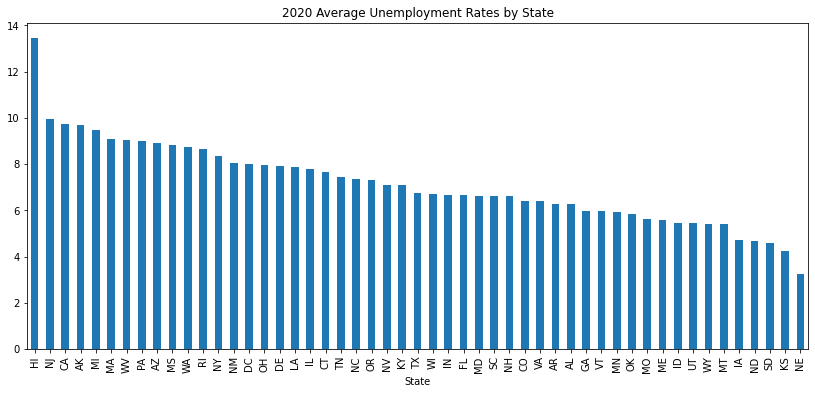

In [ ]:
# avg unemployment rate by state
state_avg_unemploy_rates = unemployment20_df.groupby('State')['Unemployment_rate_2020'].mean().sort_values(ascending=False)
state_avg_unemploy_rates.plot(kind='bar', figsize=(14,6))
plt.title('2020 Average Unemployment Rates by State')

In [ ]:
top30_unemployed_counties = unemployment20_df.sort_values('Unemployment_rate_2020', ascending=False)[:30]
top30_unemployed_counties.head()

,FIPS_Code,State,Area_name,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
207,6025,CA,Imperial County,69602.0,53949.0,15653.0,22.5,48102.0,59.811249
94,2230,AK,Skagway Municipality,606.0,476.0,130.0,21.5,74898.0,97.014366
84,2158,AK,Kusilvak Census Area,2299.0,1854.0,445.0,19.4,35369.0,45.812988
1460,28063,MS,Jefferson County,1989.0,1623.0,366.0,18.4,30871.0,67.216080
1808,34001,NJ,Atlantic County,121037.0,99546.0,21491.0,17.8,62678.0,73.063202


### US Education Data

In [ ]:
# https://docs.google.com/spreadsheets/d/1mwgAhfkk21J3AhKTjQnqw6YRUf-ADvaA/edit?usp=sharing&ouid=102105042238012798178&rtpof=true&sd=true
education_data_file_id = "1mwgAhfkk21J3AhKTjQnqw6YRUf-ADvaA"
education_data_dest_path = "/content/education.xls"
gdd.download_file_from_google_drive(file_id = education_data_file_id,
                                    dest_path = education_data_dest_path)

In [ ]:
education_df = pd.read_excel('education.xls', skiprows=4)
education_df

,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some college or associate's degree, 1990","Bachelor's degree or higher, 1990","Percent of adults with less than a high school diploma, 1990","Percent of adults with a high school diploma only, 1990","Percent of adults completing some college or associate's degree, 1990","Percent of adults with a bachelor's degree or higher, 1990","Less than a high school diploma, 2000","High school diploma only, 2000","Some college or associate's degree, 2000","Bachelor's degree or higher, 2000","Percent of adults with less than a high school diploma, 2000","Percent of adults with a high school diploma only, 2000","Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2015-19","High school diploma only, 2015-19","Some college or associate's degree, 2015-19","Bachelor's degree or higher, 2015-19","Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19"
0,0,US,United States,NaN,NaN,NaN,NaN,52373312.0,34158051.0,11650730.0,11717266.0,47.7,31.1,10.6,10.7,44535197.0,45947035.0,20794975.0,21558480.0,33.5,34.6,15.7,16.2,39343718.0,47642763.0,39571702.0,32310253.0,24.8,30.0,24.9,20.3,35715625.0,52168981.0,49864428.0,44462605.0,19.6,28.6,27.4,24.4,26472261.0,59472748.0,63756905.0,70920162.0,11.998918,26.956844,28.898697,32.145542
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,1062306.0,468269.0,136287.0,141936.0,58.7,25.9,7.5,7.8,964840.0,704207.0,278205.0,270063.0,43.5,31.8,12.5,12.2,843638.0,749591.0,553512.0,399228.0,33.1,29.4,21.7,15.7,714081.0,877216.0,746495.0,549608.0,24.7,30.4,25.9,19.0,458922.0,1022839.0,993344.0,845772.0,13.819302,30.800268,29.912098,25.468332
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,767.0,54.8,31.1,7.7,6.4,7074.0,6145.0,2104.0,2117.0,40.6,35.2,12.1,12.1,6252.0,6671.0,4912.0,3026.0,30.0,32.0,23.5,14.5,5872.0,9332.0,7413.0,4972.0,21.3,33.8,26.9,18.0,4291.0,12551.0,10596.0,9929.0,11.483395,33.588459,28.356571,26.571573
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,2038.0,59.4,26.7,7.4,6.5,18125.0,15380.0,6602.0,5498.0,39.7,33.7,14.5,12.1,17309.0,20544.0,15900.0,10870.0,26.8,31.8,24.6,16.8,17258.0,28428.0,28178.0,22146.0,18.0,29.6,29.3,23.1,13893.0,41797.0,47274.0,48148.0,9.193843,27.659616,31.284081,31.862459
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,861.0,68.8,19.0,4.9,7.3,7759.0,3671.0,1362.0,1300.0,55.1,26.1,9.7,9.2,6965.0,4258.0,2622.0,1857.0,44.4,27.1,16.7,11.8,6679.0,6124.0,4025.0,2068.0,35.3,32.4,21.3,10.9,4812.0,6396.0,4676.0,2080.0,26.786907,35.604542,26.029837,11.578713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,7214

In [ ]:
# check nulls
education19_df = education_df[['FIPS Code', 
                               'State', 
                               'Area name', 
                               'Less than a high school diploma, 2015-19',
                               'High school diploma only, 2015-19',
                               'Some college or associate\'s degree, 2015-19',
                               'Bachelor\'s degree or higher, 2015-19',
                               'Percent of adults with less than a high school diploma, 2015-19',
                               'Percent of adults with a high school diploma only, 2015-19',
                               'Percent of adults completing some college or associate\'s degree, 2015-19',
                               'Percent of adults with a bachelor\'s degree or higher, 2015-19']]
education19_df.isnull().sum()

FIPS Code                                                                    0
State                                                                        0
Area name                                                                    0
Less than a high school diploma, 2015-19                                    10
High school diploma only, 2015-19                                           10
Some college or associate's degree, 2015-19                                 10
Bachelor's degree or higher, 2015-19                                        10
Percent of adults with less than a high school diploma, 2015-19             10
Percent of adults with a high school diploma only, 2015-19                  10
Percent of adults completing some college or associate's degree, 2015-19    10
Percent of adults with a bachelor's degree or higher, 2015-19               10
dtype: int64

In [ ]:
# since the number of missing values is small, just drop
education19_df.dropna(inplace=True)

Text(0.5, 1.0, '2015-19 Education Level Percentage by State')

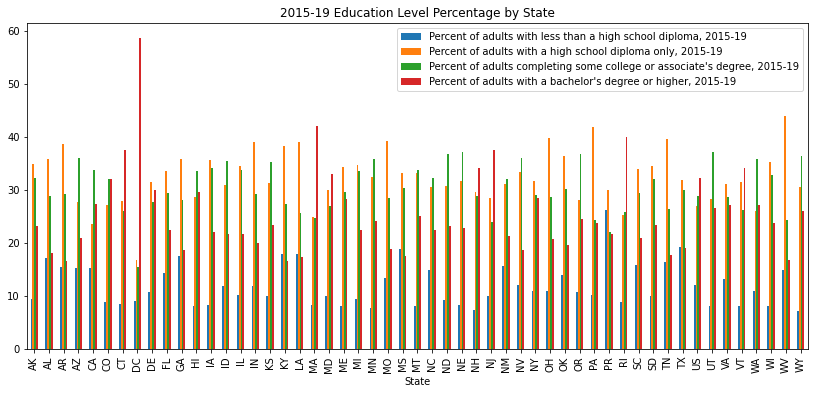

In [ ]:
state_avg_edu_level = education19_df.groupby('State')['Percent of adults with less than a high school diploma, 2015-19',
                                                      'Percent of adults with a high school diploma only, 2015-19',
                                                      'Percent of adults completing some college or associate\'s degree, 2015-19',
                                                      'Percent of adults with a bachelor\'s degree or higher, 2015-19'].\
                                                      mean()
state_avg_edu_level.plot(kind='bar', figsize=(14,6), stacked=False)
plt.title('2015-19 Education Level Percentage by State')

### US Poverty Estimates Data

In [ ]:
# https://docs.google.com/spreadsheets/d/1tIX8cst3Mr_5sdd2JtUHU-Jl0PUG2CBT/edit?usp=sharing&ouid=102105042238012798178&rtpof=true&sd=true
poverty_data_file_id = "1tIX8cst3Mr_5sdd2JtUHU-Jl0PUG2CBT"
poverty_data_dest_path = "/content/poverty.xls"
gdd.download_file_from_google_drive(file_id = poverty_data_file_id,
                                    dest_path = poverty_data_dest_path)

In [ ]:
poverty_df = pd.read_excel('poverty.xls', skiprows=4)
poverty_df

,FIPStxt,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_2013,POVALL_2019,CI90LBALL_2019,CI90UBALL_2019,PCTPOVALL_2019,CI90LBALLP_2019,CI90UBALLP_2019,POV017_2019,CI90LB017_2019,CI90UB017_2019,PCTPOV017_2019,CI90LB017P_2019,CI90UB017P_2019,POV517_2019,CI90LB517_2019,CI90UB517_2019,PCTPOV517_2019,CI90LB517P_2019,CI90UB517P_2019,MEDHHINC_2019,CI90LBINC_2019,CI90UBINC_2019,POV04_2019,CI90LB04_2019,CI90UB04_2019,PCTPOV04_2019,CI90LB04P_2019,CI90UB04P_2019
0,0,US,United States,NaN,NaN,NaN,NaN,39490096,39248096,39732096,12.3,12.2,12.4,12000470,11865995,12134945,16.8,16.6,17.0,8258906,8160650,8357162,15.8,15.6,16.0,65712,65594,65830,3457689.0,3405854.0,3509524.0,18.2,17.9,18.5
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,747478,730491,764465,15.6,15.2,16.0,233890,225712,242068,21.9,21.1,22.7,161670,154564,168776,20.7,19.8,21.6,51771,51179,52363,69236.0,65296.0,73176.0,24.2,22.8,25.6
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,6723,5517,7929,12.1,9.9,14.3,2040,1472,2608,15.9,11.5,20.3,1376,902,1850,14.4,9.4,19.4,58233,52517,63949,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,22360,18541,26179,10.1,8.4,11.8,6323,4521,8125,13.5,9.6,17.4,4641,3295,5987,13.3,9.4,17.2,59871,54593,65149,NaN,NaN,NaN,NaN,NaN,NaN
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,5909,4787,7031,27.1,22.0,32.2,2050,1560,2540,41.0,31.2,50.8,1468,1114,1822,39.5,30.0,49.0,35972,31822,40122,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,56037,WY,Sweetwater County,5.0,8.0,5.0,8.0,3453,2743,4163,8.3,6.6,10.0,1075,771,1379,10.1,7.2,13.0,644,416,872,8.2,5.3,11.1,80639,73437,87841,NaN,NaN,NaN,NaN,NaN,NaN
3189,56039,WY,Teton County,7.0,8.0,7.0,8.0,1396,1073,1719,6.0,4.6,7.4,236,151,321,5.7,3.6,7.8,142,83,201,4.7,2.7,6.7,98837,86531,111143,NaN,NaN,NaN,NaN,NaN,NaN
3190,56041,WY,Uinta County,7.0,8.0,7.0,8.0,1699,1264,2134,8.5,6.3,10.7,541,346,736,9.6,6.1,13.1,336,193,479,7.8,4.5,11.1,70756,63191,78321,NaN,NaN,NaN,NaN,NaN,NaN
3191,56043,WY,Washakie County,7.0,11.0,7.0,11.0,845,626,1064,11.1,8.2,14.0,237,152,322,13.9,8.9,18.9,160,94,226,12.3,7.2,17.4,55122,50050,60194,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# check nulls
poverty19_df = poverty_df[['FIPStxt', 'Stabr', 'Area_name', 'PCTPOVALL_2019', 'PCTPOV017_2019',
                           'PCTPOV517_2019', 'MEDHHINC_2019']]
poverty19_df.isnull().sum()

FIPStxt           0
Stabr             0
Area_name         0
PCTPOVALL_2019    0
PCTPOV017_2019    0
PCTPOV517_2019    0
MEDHHINC_2019     0
dtype: int64

Text(0.5, 1.0, '2019 Poverty Rates by State')

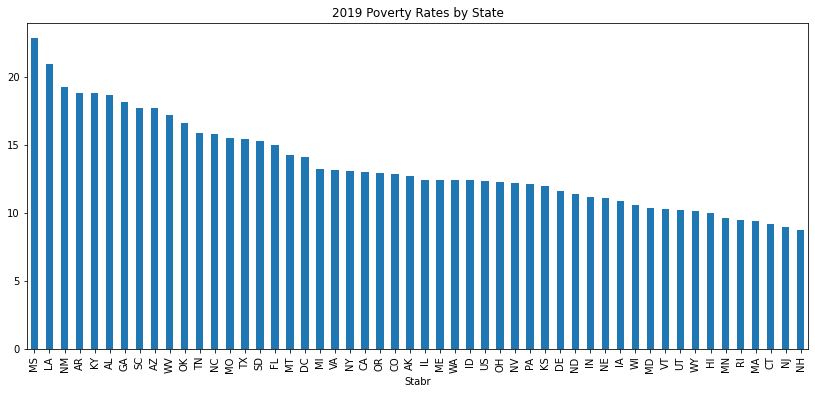

In [ ]:
state_avg_poverty_rates = poverty19_df.groupby('Stabr')['PCTPOVALL_2019'].mean().sort_values(ascending=False)
state_avg_poverty_rates.plot(kind='bar', figsize=(14,6))
plt.title('2019 Poverty Rates by State')

# Data Wrangling

## Joined US Census & Vaccine Hesitancy 

In [ ]:
# join the filtered census and vaccine hesitancy dataframes
join_query = """SELECT "FIPS CODE", "County Name", "State", 
                TOT_POP, TOT_MALE, TOT_FEMALE, AVG_AGE,	AVG_MALE_AGE,	AVG_FEMALE_AGE,
                "Estimated hesitant", "Estimated hesitant or unsure", "Estimated strongly hesitant", 
                "Social Vulnerability Index (SVI)", "SVI Category", 
                "Percent adults fully vaccinated against COVID-19 (as of 6/10/21)" AS Vaccinated,
                "CVAC level of concern for vaccination rollout", "CVAC Level Of Concern"
                FROM avged_census_df AS c
                LEFT JOIN vaccine_hesitancy_df AS v
                ON c.CTYNAME = v."County Name" AND c.STNAME = v.State
                """
census_hesitancy_df = pysqldf(join_query)
census_hesitancy_df = census_hesitancy_df.dropna()
census_hesitancy_df

,FIPS Code,County Name,State,TOT_POP,TOT_MALE,TOT_FEMALE,AVG_AGE,AVG_MALE_AGE,AVG_FEMALE_AGE,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,Vaccinated,CVAC level of concern for vaccination rollout,CVAC Level Of Concern
0,45001.0,Abbeville County,South Carolina,24527,11871,12656,42,41,43,0.1406,0.2215,0.0790,0.86,Very High Vulnerability,0.346,0.81,Very High Concern
1,22001.0,Acadia Parish,Louisiana,62045,30359,31686,38,36,39,0.1868,0.2597,0.1135,0.92,Very High Vulnerability,0.378,0.72,High Concern
2,51001.0,Accomack County,Virginia,32316,15728,16588,43,42,44,0.0613,0.1235,0.0424,0.80,Very High Vulnerability,0.535,0.50,Moderate Concern
3,16001.0,Ada County,Idaho,481587,241132,240455,38,37,38,0.1771,0.2342,0.1140,0.14,Very Low Vulnerability,0.547,0.13,Very Low Concern
4,19001.0,Adair County,Iowa,7152,3562,3590,42,41,44,0.1362,0.1966,0.0841,0.05,Very Low Vulnerability,0.473,0.01,Very Low Concern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,6115.0,Yuba County,California,78668,39819,38849,35,34,36,0.0821,0.1288,0.0410,0.94,Very High Vulnerability,0.366,0.79,High Concern
3136,2290.0,Yukon-Koyukuk Census Area,Alaska,5230,2760,2470,36,37,35,0.2361,0.2884,0.1704,0.88,Very High Vulnerability,0.697,0.93,Very High Concern
3137,4027.0,Yuma County,Arizona,213787,110106,103681,38,37,39,0.1475,0.2352,0.1122,0.99,Very High Vulnerability,0.519,0.96,Very High Concern
3138,8125.0,Yuma County,Colorado,10019,5015,5004,38,37,39,0.0945,0.1484,0.0582,0.56,Moderate Vulnerability,0.238,0.47,Moderate Concern


## Joined JHU COVID-19 Data & Vaccine Hesitancy

In [ ]:
#6.10 merge
df_jhu_covid_us_date_update=df_jhu_covid_us_date[df_jhu_covid_us_date['date']=='2021-06-10']
df_jhu_covid_us_date_update['FIPS Code']=df_jhu_covid_us_date_update['FIPS Code'].fillna(0).astype('int64')
covid_vaccine=pd.merge(df_jhu_covid_us_date_update,vaccine_hesitancy_df, on=['FIPS Code'])#,'Lat','Long_'
covid_vaccine=covid_vaccine.fillna(0)
covid_vaccine

,FIPS Code,County_Name,Province_State,Latitude,Longitude,date,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio,County Name,State,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern
0,1001,Autauga,Alabama,32.539527,-86.644082,2021-06-10,7209.0,113.0,"Autauga, Alabama, US",12903.399023,1.567485,Autauga County,Alabama,0.288,0.1685,0.2233,0.1272,0.44,Moderate Vulnerability,0.61,High Concern
1,1003,Baldwin,Alabama,30.727750,-87.722071,2021-06-10,21755.0,313.0,"Baldwin, Alabama, US",9745.379288,1.438750,Baldwin County,Alabama,0.336,0.1544,0.1988,0.1169,0.22,Low Vulnerability,0.23,Low Concern
2,1005,Barbour,Alabama,31.868263,-85.387129,2021-06-10,2346.0,59.0,"Barbour, Alabama, US",9503.362230,2.514919,Barbour County,Alabama,0.257,0.1676,0.2337,0.1274,1.00,Very High Vulnerability,0.89,Very High Concern
3,1007,Bibb,Alabama,32.996421,-87.125115,2021-06-10,2670.0,64.0,"Bibb, Alabama, US",11922.836474,2.397004,Bibb County,Alabama,0.222,0.1808,0.2526,0.1390,0.60,High Vulnerability,0.76,High Concern
4,1009,Blount,Alabama,33.982109,-86.567906,2021-06-10,6921.0,139.0,"Blount, Alabama, US",11968.664615,2.008380,Blount County,Alabama,0.215,0.1854,0.2362,0.1416,0.42,Moderate Vulnerability,0.80,High Concern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,56037,Sweetwater,Wyoming,41.659439,-108.882788,2021-06-10,4617.0,39.0,"Sweetwater, Wyoming, US",10903.809366,0.844704,Sweetwater County,Wyoming,0.348,0.2184,0.2843,0.1584,0.37,Low Vulnerability,0.56,Moderate Concern
3112,56039,Teton,Wyoming,43.935225,-110.589080,2021-06-10,3793.0,11.0,"Teton, Wyoming, US",16165.189226,0.290008,Teton County,Wyoming,0.789,0.2050,0.2671,0.1472,0.11,Very Low Vulnerability,0.44,Moderate Concern
3113,56041,Uinta,Wyoming,41.287818,-110.547578,2021-06-10,2293.0,13.0,"Uinta, Wyoming, US",11336.893108,0.566943,Uinta County,Wyoming,0.388,0.2184,0.2843,0.1584,0.45,Moderate Vulnerability,0.48,Moderate Concern
3114,56043,Washakie,Wyoming,43.904516,-107.680187,2021-06-10,925.0,26.0,"Washakie, Wyoming, US",11851.377322,2.810811,Washakie County,Wyoming,0.364,0.2283,0.2943,0.1687,0.37,Low Vulnerability,0.69,High Concern


In [ ]:
# complete merge
df_jhu_covid_us_date_=df_jhu_covid_us_date.copy()
df_jhu_covid_us_date_['FIPS Code']=df_jhu_covid_us_date_['FIPS Code'].fillna(0).astype('int64')
covid_vaccine_complete=pd.merge(df_jhu_covid_us_date_,vaccine_hesitancy_df, on=['FIPS Code'])#,'Lat','Long_'
covid_vaccine_complete=covid_vaccine_complete.fillna(0)
covid_vaccine_complete

,FIPS Code,County_Name,Province_State,Latitude,Longitude,date,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio,County Name,State,Percent adults fully vaccinated against COVID-19 (as of 6/10/21),Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern
0,1001,Autauga,Alabama,32.539527,-86.644082,2021-05-05,6910.0,107.0,"Autauga, Alabama, US",12368.218511,1.548480,Autauga County,Alabama,0.288,0.1685,0.2233,0.1272,0.44,Moderate Vulnerability,0.61,High Concern
1,1001,Autauga,Alabama,32.539527,-86.644082,2021-04-28,6889.0,107.0,"Autauga, Alabama, US",12330.630582,1.553201,Autauga County,Alabama,0.288,0.1685,0.2233,0.1272,0.44,Moderate Vulnerability,0.61,High Concern
2,1001,Autauga,Alabama,32.539527,-86.644082,2021-09-28,9691.0,137.0,"Autauga, Alabama, US",17345.934239,1.413683,Autauga County,Alabama,0.288,0.1685,0.2233,0.1272,0.44,Moderate Vulnerability,0.61,High Concern
3,1001,Autauga,Alabama,32.539527,-86.644082,2021-05-17,7005.0,108.0,"Autauga, Alabama, US",12538.259142,1.541756,Autauga County,Alabama,0.288,0.1685,0.2233,0.1272,0.44,Moderate Vulnerability,0.61,High Concern
4,1001,Autauga,Alabama,32.539527,-86.644082,2021-03-11,6400.0,93.0,"Autauga, Alabama, US",11455.368809,1.453125,Autauga County,Alabama,0.288,0.1685,0.2233,0.1272,0.44,Moderate Vulnerability,0.61,High Concern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807006,56045,Weston,Wyoming,43.839612,-104.567488,2021-05-24,652.0,5.0,"Weston, Wyoming, US",9412.444059,0.766871,Weston County,Wyoming,0.311,0.2283,0.2943,0.1687,0.35,Low Vulnerability,0.51,Moderate Concern
807007,56045,Weston,Wyoming,43.839612,-104.567488,2021-06-08,655.0,5.0,"Weston, Wyoming, US",9455.752851,0.763359,Weston County,Wyoming,0.311,0.2283,0.2943,0.1687,0.35,Low Vulnerability,0.51,Moderate Concern
807008,56045,Weston,Wyoming,43.839612,-104.567488,2021-11-09,1161.0,9.0,"Weston, Wyoming, US",16760.502382,0.775194,Weston County,Wyoming,0.311,0.2283,0.2943,0.1687,0.35,Low Vulnerability,0.51,Moderate Concern
807009,56045,Weston,Wyoming,43.839612,-104.567488,2021-03-21,631.0,5.0,"Weston, Wyoming, US",9109.282518,0.792393,Weston County,Wyoming,0.311,0.2283,0.2943,0.1687,0.35,Low Vulnerability,0.51,Moderate Concern


## Joined USDA Sociological Data

In [ ]:
education19_df.rename(columns={'FIPS Code':'FIPS_Code'}, inplace=True)
poverty19_df.rename(columns={'FIPStxt':'FIPS_Code'}, inplace=True)
usda_data = unemployment20_df.merge(education19_df, on='FIPS_Code').merge(poverty19_df,on='FIPS_Code')
usda_data.drop(columns=['State_y', 'Area name', 'Stabr', 'Area_name_y'], inplace=True)
usda_data.rename(columns={'State_x':'State', 'Area_name_x':'Area_name'}, inplace=True)
usda_data

,FIPS_Code,State,Area_name,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019,"Less than a high school diploma, 2015-19","High school diploma only, 2015-19","Some college or associate's degree, 2015-19","Bachelor's degree or higher, 2015-19","Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",PCTPOVALL_2019,PCTPOV017_2019,PCTPOV517_2019,MEDHHINC_2019
0,1000,AL,Alabama,2230118.0,2099062.0,131056.0,5.9,51771.0,100.000000,458922.0,1022839.0,993344.0,845772.0,13.819302,30.800268,29.912098,25.468332,15.6,21.9,20.7,51771
1,1001,AL,Autauga County,25838.0,24576.0,1262.0,4.9,58233.0,112.481888,4291.0,12551.0,10596.0,9929.0,11.483395,33.588459,28.356571,26.571573,12.1,15.9,14.4,58233
2,1003,AL,Baldwin County,96763.0,91338.0,5425.0,5.6,59871.0,115.645828,13893.0,41797.0,47274.0,48148.0,9.193843,27.659616,31.284081,31.862459,10.1,13.5,13.3,59871
3,1005,AL,Barbour County,8587.0,7982.0,605.0,7.0,35972.0,69.482918,4812.0,6396.0,4676.0,2080.0,26.786907,35.604542,26.029837,11.578713,27.1,41.0,39.5,35972
4,1007,AL,Bibb County,8640.0,8067.0,573.0,6.6,47918.0,92.557610,3386.0,7256.0,3848.0,1678.0,20.942602,44.878773,23.800098,10.378526,20.3,25.9,25.2,47918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,56037,WY,Sweetwater County,20840.0,19308.0,1532.0,7.4,80639.0,121.899567,2017.0,9239.0,10415.0,6291.0,7.213361,33.041271,37.246979,22.498390,8.3,10.1,8.2,80639
3188,56039,WY,Teton County,15204.0,14292.0,912.0,6.0,98837.0,149.408936,834.0,2577.0,4037.0,9875.0,4.814409,14.876176,23.304277,57.005138,6.0,5.7,4.7,98837
3189,56041,WY,Uinta County,9312.0,8730.0,582.0,6.3,70756.0,106.959732,941.0,5383.0,4562.0,2078.0,7.258562,41.522678,35.189754,16.029003,8.5,9.6,7.8,70756
3190,56043,WY,Washakie County,4004.0,3793.0,211.0,5.3,55122.0,83.326279,568.0,1650.0,2031.0,1297.0,10.241615,29.751171,36.620987,23.386225,11.1,13.9,12.3,55122


# Exploratory Data Analysis 


## Geographical Data Visualization

**Since there is geographical information ('latitude' and 'longitude' fields) in Covid Dataset, we'll try visualizing using a map of US to see different Counties' situation.**

### Construct the geologic Info of DataFrame 

*   We load the shape of US as shp file for plotting the whole map of US. 
*   We convert the Latitude and Longitude into an geometry column.   
*   We plot the Vaccinated Rate against COVID-19 (as of 6/10/21) on US map to see its county-granularity distribution. 

In [ ]:
#big map:general_view
#vaccinated Rate related to (Latitude & Longitude)
#https://drive.google.com/file/d/15HDc-NCRAb0ywF_b9mRDqonR_sWZTPir/view?usp=sharing
#https://drive.google.com/file/d/1LWFDnJFDx82hNykRMaubKWi0miSUsQCM/view?usp=sharing
us_county_id = "15HDc-NCRAb0ywF_b9mRDqonR_sWZTPir"
us_county_id_2 = '1LWFDnJFDx82hNykRMaubKWi0miSUsQCM'
us_county_path = "/content/usa-states-census-2014.shp"
us_county_path_2 = "/content/usa-states-census-2014.shx"
gdd.download_file_from_google_drive(file_id = us_county_id,
                                    dest_path = us_county_path)
gdd.download_file_from_google_drive(file_id = us_county_id_2,
                                    dest_path = us_county_path_2)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
states = geopandas.read_file('/content/usa-states-census-2014.shp')

    Latitude  ...                    geometry
0  32.539527  ...  POINT (-86.64408 32.53953)
1  30.727750  ...  POINT (-87.72207 30.72775)
2  31.868263  ...  POINT (-85.38713 31.86826)
3  32.996421  ...  POINT (-87.12511 32.99642)
4  33.982109  ...  POINT (-86.56791 33.98211)

[5 rows x 4 columns]


Text(156.375, 0.5, 'Latitude')

<Figure size 1440x1440 with 0 Axes>

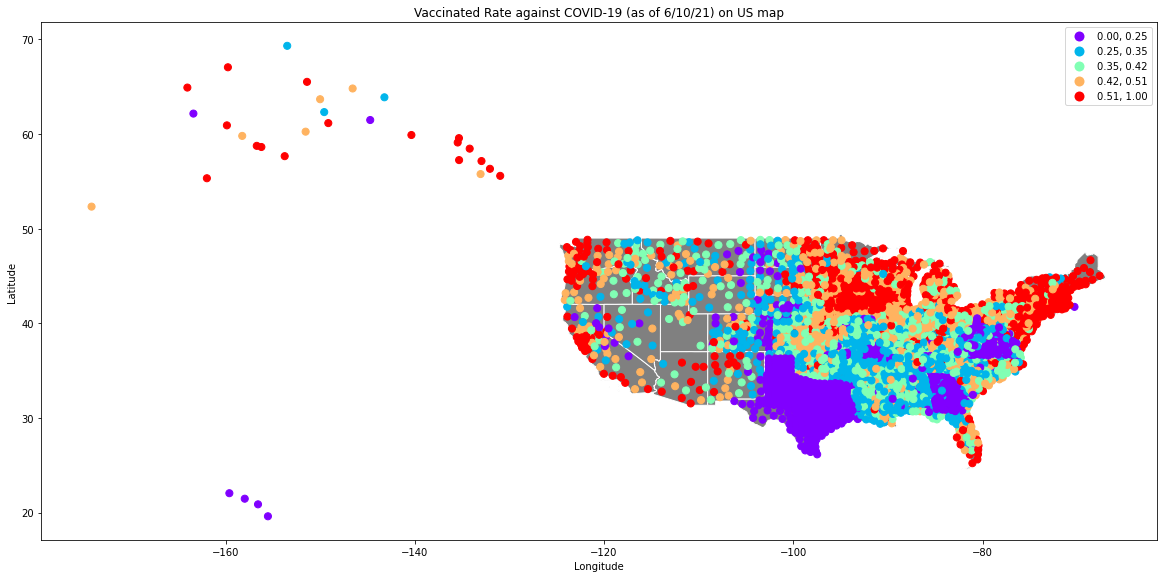

In [ ]:
#visualize the vaccinate rate in geographic ares to see the distribution associated with different counties
covid_vaccine_plot=covid_vaccine[['Latitude','Longitude','Percent adults fully vaccinated against COVID-19 (as of 6/10/21)']]
xy = [Point(xy) for xy in zip(covid_vaccine_plot.Longitude,covid_vaccine_plot.Latitude)]
plt.figure(figsize=(20, 20))
geo_data=geopandas.GeoDataFrame(covid_vaccine_plot,geometry=xy)
print(geo_data.head())
geo_data.plot(ax=states.plot(figsize=(20,20),legend=True,edgecolor='white',color='gray'),column='Percent adults fully vaccinated against COVID-19 (as of 6/10/21)', cmap='rainbow',scheme='quantiles',legend=True,figsize=(20,20),marker='o', markersize=50)
plt.title('Vaccinated Rate against COVID-19 (as of 6/10/21) on US map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [ ]:
#View Some Counties' vaccinated rate 
total_people=avged_census_df[['CTYNAME','TOT_POP']].copy()
total_people.rename(columns={'CTYNAME':'County Name'},inplace=True)
total_people.rename(columns={'TOT_POP':'total_people'},inplace=True)
total_people_=pd.merge(total_people,vaccine_hesitancy_df,how='left',on=['County Name'])[['FIPS Code','total_people','County Name']]
#total_people['County_Name'] = total_people['County_Name'].map(lambda x: x.rstrip('County'))
covid_us=pd.merge(df_jhu_covid_us_date,total_people_,how='left',on=['FIPS Code'])
covid_us['Confirmed_Rate(%)']=(covid_us['Confirmed']/covid_us['total_people'])*100
covid_us['Deaths_Rate(%)']=(covid_us['Deaths']/covid_us['total_people'])*100
covid_us

,FIPS Code,County_Name,Province_State,Latitude,Longitude,date,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio,total_people,County Name,Confirmed_Rate(%),Deaths_Rate(%)
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2021-05-05,6910.0,107.0,"Autauga, Alabama, US",12368.218511,1.548480,55869.0,Autauga County,12.368219,0.191519
1,1003.0,Baldwin,Alabama,30.727750,-87.722071,2021-05-05,20993.0,306.0,"Baldwin, Alabama, US",9404.033436,1.457629,223234.0,Baldwin County,9.404033,0.137076
2,1003.0,Baldwin,Alabama,30.727750,-87.722071,2021-05-05,20993.0,306.0,"Baldwin, Alabama, US",9404.033436,1.457629,44890.0,Baldwin County,46.765427,0.681666
3,1005.0,Barbour,Alabama,31.868263,-85.387129,2021-05-05,2302.0,56.0,"Barbour, Alabama, US",9325.123552,2.432667,24686.0,Barbour County,9.325124,0.226849
4,1005.0,Barbour,Alabama,31.868263,-85.387129,2021-05-05,2302.0,56.0,"Barbour, Alabama, US",9325.123552,2.432667,16441.0,Barbour County,14.001581,0.340612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762130,56039.0,Teton,Wyoming,43.935225,-110.589080,2021-10-05,4953.0,13.0,"Teton, Wyoming, US",21108.932833,0.262467,6147.0,Teton County,80.575891,0.211485
3762131,56039.0,Teton,Wyoming,43.935225,-110.589080,2021-10-05,4953.0,13.0,"Teton, Wyoming, US",21108.932833,0.262467,23464.0,Teton County,21.108933,0.055404
3762132,56041.0,Uinta,Wyoming,41.287818,-110.547578,2021-10-05,3578.0,25.0,"Uinta, Wyoming, US",17690.101849,0.698714,20226.0,Uinta County,17.690102,0.123603
3762133,56043.0,Washakie,Wyoming,43.904516,-107.680187,2021-10-05,1422.0,27.0,"Washakie, Wyoming, US",18219.090327,1.898734,7805.0,Washakie County,18.219090,0.345932


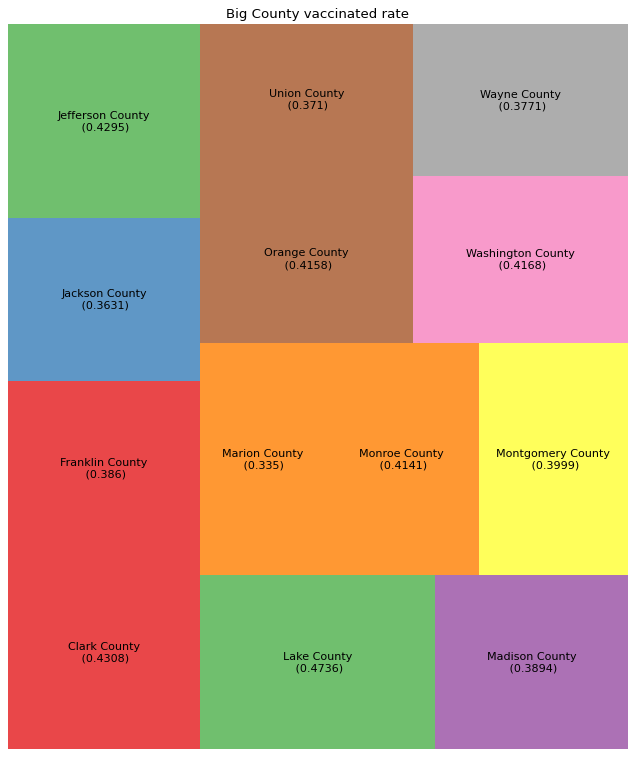

In [ ]:
#County with big population's vaccinated rate
covid_us_County=covid_us.groupby(['County Name',]).sum().reset_index()[['County Name','total_people']]
covid_us_County_BigPop=covid_us_County[covid_us_County['total_people']>5000000000]
covid_us_County_Big=pd.merge(covid_us_County_BigPop,covid_vaccine,how='left',on=['County Name'])
covid_us_County_Big_g=covid_us_County_Big.groupby(['County Name']).mean().round(4).reset_index()
geo_data_v=covid_us_County_Big_g[['County Name','Percent adults fully vaccinated against COVID-19 (as of 6/10/21)']].copy()
geo_data_v=geo_data_v[geo_data_v['Percent adults fully vaccinated against COVID-19 (as of 6/10/21)']!=0]

labels = geo_data_v.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = geo_data_v['Percent adults fully vaccinated against COVID-19 (as of 6/10/21)'].values.tolist()
colors = [plt.cm.Set1(i/float(len(labels))) for i in range(len(labels))]
plt.figure(figsize=(10,12),dpi= 80)

squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
plt.title('Big County vaccinated rate')
plt.rc('font',size=10)
plt.axis('off')
plt.tick_params(top='off',right='off')

## Correlations Among COVID Features & Vaccine Hesitancy


                              Confirmed  ...  Estimated strongly hesitant
Confirmed                      1.000000  ...                    -0.168812
Deaths                         0.956799  ...                    -0.161127
Incident_Rate                  0.049953  ...                     0.185539
Case_Fatality_Ratio           -0.054227  ...                     0.103852
vaccinated Rate                0.126173  ...                    -0.105105
Estimated hesitant            -0.168132  ...                     0.975208
Estimated hesitant or unsure  -0.177282  ...                     0.938042
Estimated strongly hesitant   -0.168812  ...                     1.000000

[8 rows x 8 columns]


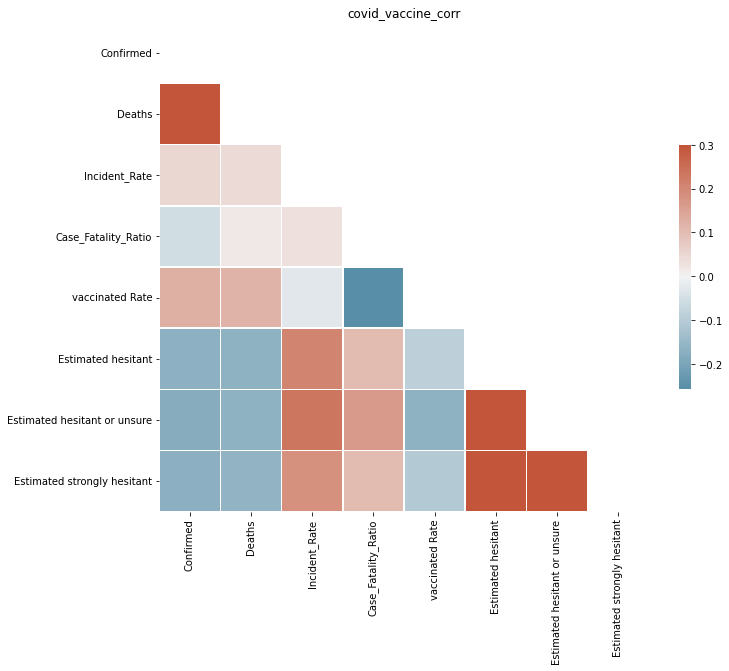

In [ ]:
#covid cases, deaths, etc &vaccine hesitancy correlation
import numpy as np
covid_vaccine_hm=covid_vaccine.copy()
covid_vaccine_hm.rename(columns={'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)':'vaccinated Rate'},inplace=True)
covid_vaccine_corr=covid_vaccine_hm[['Confirmed','Deaths','Incident_Rate','Case_Fatality_Ratio','vaccinated Rate','Estimated hesitant','Estimated hesitant or unsure','Estimated strongly hesitant']].corr()
#Incident_Rate: Incidence Rate = cases per 100,000 persons.
#Case_Fatality_Ratio (%): Case-Fatality Ratio (%) = Number recorded deaths / Number cases.
print(covid_vaccine_corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(covid_vaccine_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title('covid_vaccine_corr')
sns.heatmap(covid_vaccine_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Let us focus on some of them to further see the relationship between them.

In [ ]:
import numpy as np
sns.set()
plot=covid_vaccine[["Confirmed","Deaths",'Estimated hesitant or unsure']]
pt=plot.pivot_table(index="Confirmed",columns="Deaths",values='Estimated hesitant or unsure',aggfunc=np.mean).fillna(0)

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

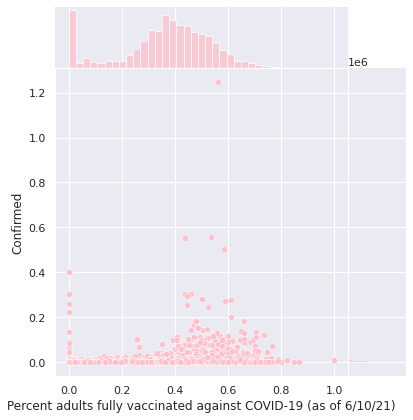

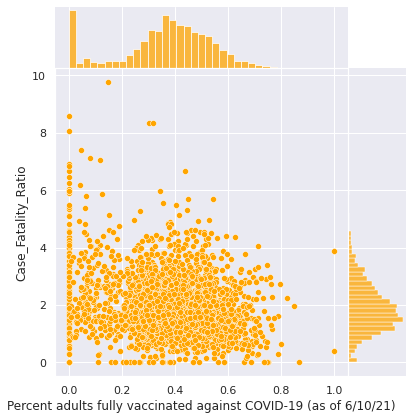

In [ ]:
#analyze the relationship between some important features
#Vaccinated rate & Confirmed population
sns.jointplot(x='Percent adults fully vaccinated against COVID-19 (as of 6/10/21)', y='Confirmed',data=covid_vaccine, 
                   space=0,
                   color='pink')
#Vaccinated rate & Case_Fatality_Ratio
sns.jointplot(x='Percent adults fully vaccinated against COVID-19 (as of 6/10/21)', y='Case_Fatality_Ratio',data=covid_vaccine, 
                   space=0,
                   color='orange')#Case_Fatality_Ratio (%): Case-Fatality Ratio (%) = Number recorded deaths / Number cases.

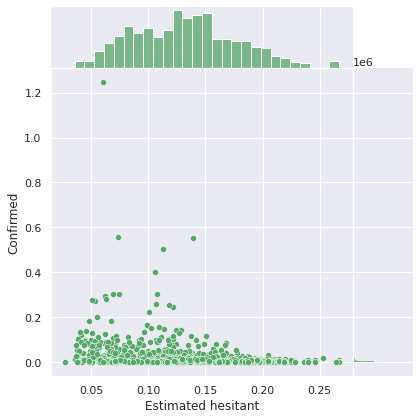

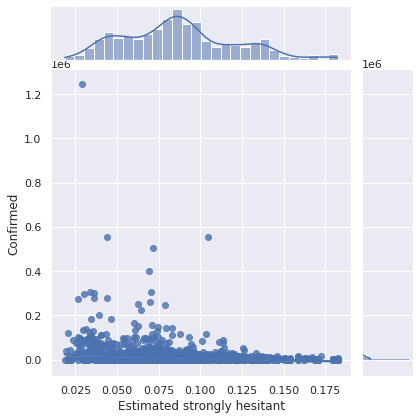

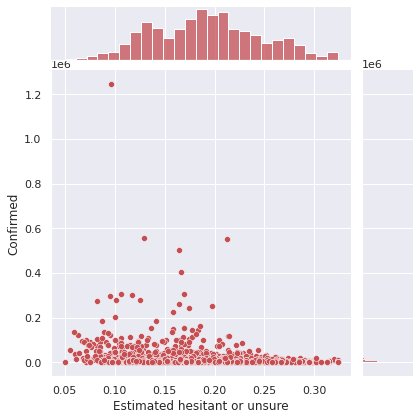

In [ ]:
#Connect Confirmed population to the Estimated hesitant 
sns.jointplot(y="Confirmed", x='Estimated hesitant',data=covid_vaccine, 
                   space=0,
                   color='g')
sns.jointplot(data=covid_vaccine, y="Confirmed", x='Estimated strongly hesitant',kind="reg")#, hue="species")
sns.jointplot(data=covid_vaccine, y="Confirmed", x='Estimated hesitant or unsure',color='r')#, hue="species")

In [ ]:
plot_strong=covid_vaccine[["Confirmed",'Estimated strongly hesitant']]
plot_est=covid_vaccine[["Confirmed",'Estimated hesitant']]
plot_vac=covid_vaccine[["Confirmed",'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)']]
# plt.figure(figsize=(20,20))
# sns.pairplot(plot_vac)

## COVID-19 Data Time Series Visualization

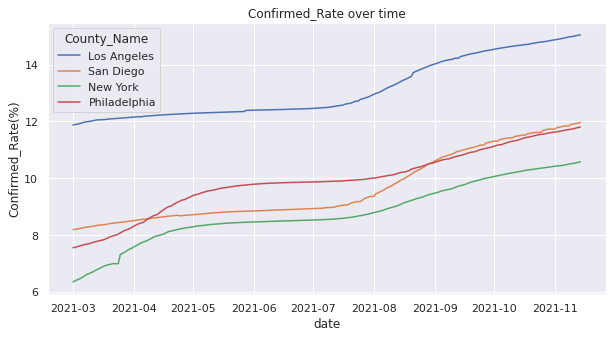

In [ ]:
#Big County view
#Diagrams of the Confirmed_Rate(%) over time
County_covid=covid_us[#(covid_us['County_Name']=='Dallas')|
                                  (covid_us['County_Name']=='San Diego')|
                                  (covid_us['County_Name']=='New York')|
                                  (covid_us['County_Name']=='Los Angeles')|
                                  (covid_us['County_Name']=='Philadelphia')]

plt.figure(figsize=(10,5))
plt.title('Confirmed_Rate over time')
sns.lineplot(x="date", y="Confirmed_Rate(%)",
             hue="County_Name", 
             data=County_covid)


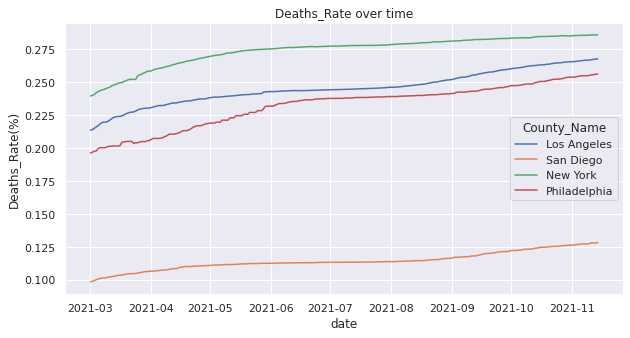

In [ ]:
#Death_rate
plt.figure(figsize=(10,5))
plt.title('Deaths_Rate over time')
sns.lineplot(x="date", y="Deaths_Rate(%)",
             hue="County_Name", 
             data=County_covid)

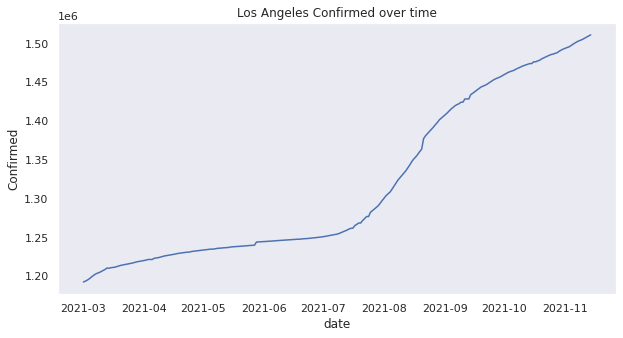

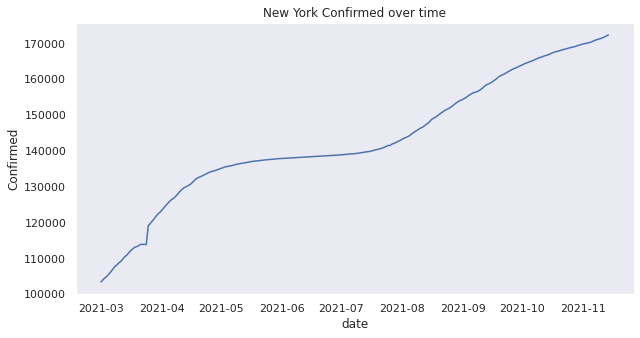

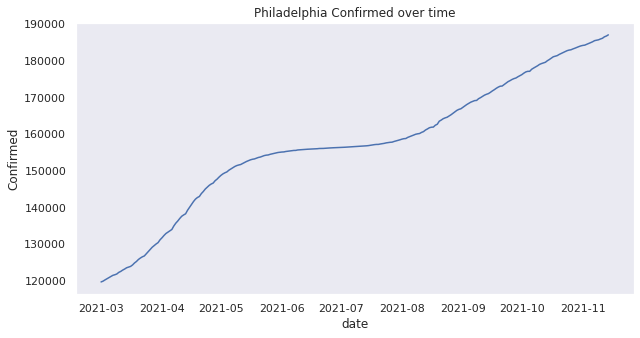

In [ ]:
#By County
#Los Angeles
Los_covid=covid_us[(covid_us['County_Name']=='Los Angeles')]
plt.figure(figsize=(10,5))
sns.set_theme(style="dark")
plt.title('Los Angeles Confirmed over time')
sns.lineplot(x="date", y="Confirmed",
             
             #hue="County_Name", 
             data=Los_covid)

#New York
NewYork_covid=covid_us[(covid_us['County_Name']=='New York')]
plt.figure(figsize=(10,5))
plt.title('New York Confirmed over time')
sns.lineplot(x="date", y="Confirmed",
             #"g",
             #hue="County_Name", 
             data=NewYork_covid)
#Philadelphia
Philly_covid=covid_us[(covid_us['County_Name']=='Philadelphia')]
plt.figure(figsize=(10,5))
plt.title('Philadelphia Confirmed over time')
sns.lineplot(x="date", y="Confirmed",
             #"g",
             #hue="County_Name", 
             data=Philly_covid)

In [ ]:
#covid_us['month']=covid_us['month']
import calendar
covid_us['day'] = covid_us['date'].dt.day 
covid_us['Month'] = covid_us['date'].dt.month 
covid_us['Weekday'] = covid_us['date'].dt.weekday
covid_us['Week'] = covid_us['date'].dt.week
covid_us

,FIPS Code,County_Name,Province_State,Latitude,Longitude,date,Confirmed,Deaths,Combined_Key,Incident_Rate,Case_Fatality_Ratio,total_people,County Name,Confirmed_Rate(%),Deaths_Rate(%),day,Month,Weekday,Week
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2021-05-05,6910.0,107.0,"Autauga, Alabama, US",12368.218511,1.548480,55869.0,Autauga County,12.368219,0.191519,5,5,2,18
1,1003.0,Baldwin,Alabama,30.727750,-87.722071,2021-05-05,20993.0,306.0,"Baldwin, Alabama, US",9404.033436,1.457629,223234.0,Baldwin County,9.404033,0.137076,5,5,2,18
2,1003.0,Baldwin,Alabama,30.727750,-87.722071,2021-05-05,20993.0,306.0,"Baldwin, Alabama, US",9404.033436,1.457629,44890.0,Baldwin County,46.765427,0.681666,5,5,2,18
3,1005.0,Barbour,Alabama,31.868263,-85.387129,2021-05-05,2302.0,56.0,"Barbour, Alabama, US",9325.123552,2.432667,24686.0,Barbour County,9.325124,0.226849,5,5,2,18
4,1005.0,Barbour,Alabama,31.868263,-85.387129,2021-05-05,2302.0,56.0,"Barbour, Alabama, US",9325.123552,2.432667,16441.0,Barbour County,14.001581,0.340612,5,5,2,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762130,56039.0,Teton,Wyoming,43.935225,-110.589080,2021-10-05,4953.0,13.0,"Teton, Wyoming, US",21108.932833,0.262467,6147.0,Teton County,80.575891,0.211485,5,10,1,40
3762131,56039.0,Teton,Wyoming,43.935225,-110.589080,2021-10-05,4953.0,13.0,"Teton, Wyoming, US",21108.932833,0.262467,23464.0,Teton County,21.108933,0.055404,5,10,1,40
3762132,56041.0,Uinta,Wyoming,41.287818,-110.547578,2021-10-05,3578.0,25.0,"Uinta, Wyoming, US",17690.101849,0.698714,20226.0,Uinta County,17.690102,0.123603,5,10,1,40
3762133,56043.0,Washakie,Wyoming,43.904516,-107.680187,2021-10-05,1422.0,27.0,"Washakie, Wyoming, US",18219.090327,1.898734,7805.0,Washakie County,18.219090,0.345932,5,10,1,40


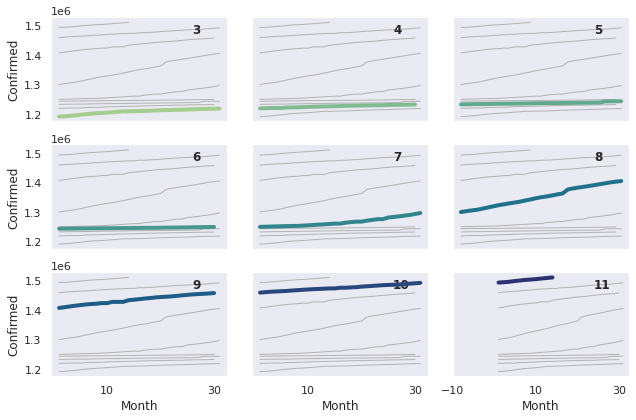

In [ ]:
#focus on August 
import seaborn as sns

sns.set_theme(style="dark")


# Plot each year's time series in its own facet
#Los Angeles
Los_covid=covid_us[(covid_us['County_Name']=='Los Angeles')]
g = sns.relplot(
    data=Los_covid[['Confirmed','Month','day']],
    x="day", y="Confirmed", col="Month", hue="Month",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for Month, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, Month, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=Los_covid[['Confirmed','Month','day']], x="day", y="Confirmed", units="Month",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
#plt.title("Confirmed in different months")
g.set_titles("")
g.set_axis_labels("Month", "Confirmed")
g.tight_layout()

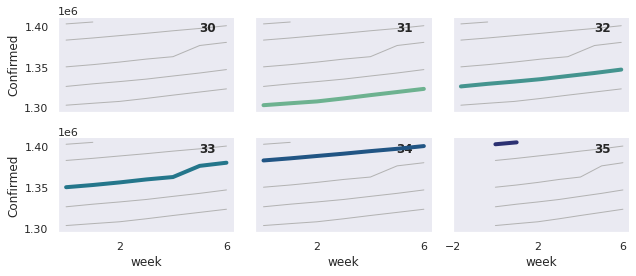

In [ ]:
#focus on August 
sns.set_theme(style="dark")
#flights = sns.load_dataset("flights")

# Plot each year's time series in its own facet
#Los Angeles
Los_covid=covid_us[(covid_us['County_Name']=='Los Angeles')&(covid_us['Month']==8 
                                                             )]#&((covid_us['Month']==8))
g = sns.relplot(
    data=Los_covid[['Confirmed','Week','Weekday']],
    x="Weekday", y="Confirmed", col="Week", hue="Week",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for Month, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, Month, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=Los_covid[['Confirmed','Week','Weekday']], x="Weekday", y="Confirmed", units="Week",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
"Confirmed in different months"
g.set_axis_labels("week", "Confirmed")
g.tight_layout()

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


In [ ]:
#Los_covid.sort_values(by=['date']).reset_index()[['Confirmed']]
Los_covid_time=Los_covid.sort_values(by=['date']).reset_index()[['Confirmed']]
NewYork_covid_time=NewYork_covid.sort_values(by=['date']).reset_index()[['Confirmed']]


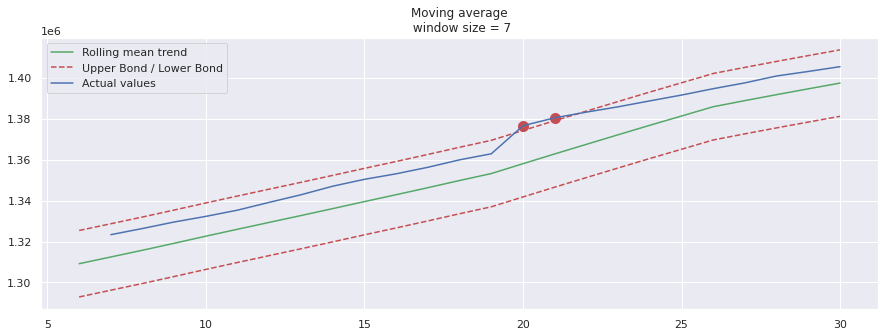

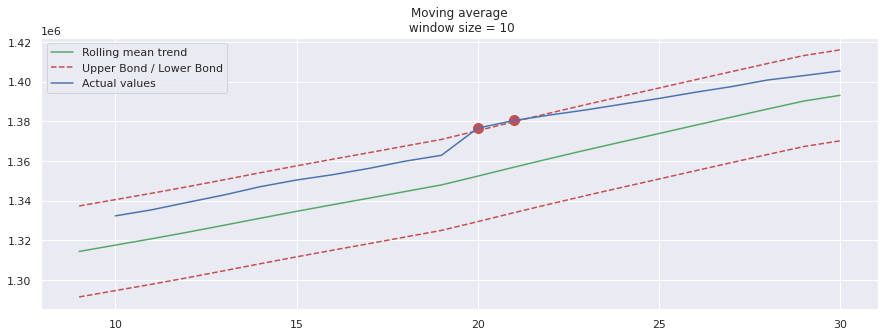

In [ ]:
#Add confidence interval and anomalies detection
plotMovingAverage(Los_covid_time,7,plot_intervals=True, plot_anomalies=True)
plotMovingAverage(Los_covid_time,10,plot_intervals=True, plot_anomalies=True)

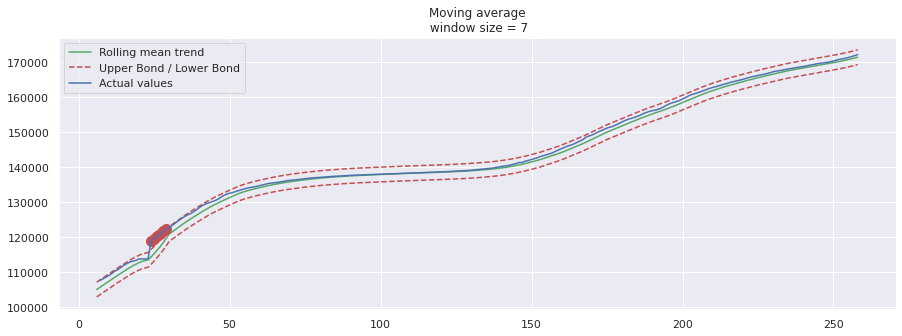

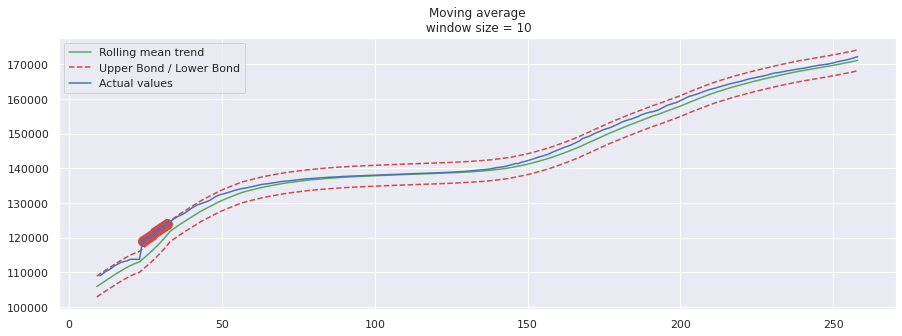

In [ ]:
plotMovingAverage(NewYork_covid_time,7,plot_intervals=True, plot_anomalies=True)
plotMovingAverage(NewYork_covid_time,10,plot_intervals=True, plot_anomalies=True)

## Census Data Population vs Age Group Bubble Charts

In [ ]:
# counties with the most people in each age group as a ratio of total population in seaborn bubble charts
import plotly.express as px

ageGroups = {1:"0 - 19", 2:"20 - 34", 3:"35 - 49", 4:"50 - 59", 5:"60+"}
size = [20, 40, 60, 80, 100, 80, 60, 40, 20, 40]

def makeBubblePlots(group, df):
  plot_df = df.sort_values('TOT_POP_RATIO', ascending=True).head(25)

  fig = px.scatter(plot_df, x="TOT_POP", y="FEMALE_POP_RATIO",
	         size=plot_df["TOT_POP_RATIO"] * 100, color="STNAME",
                 hover_data=["CTYNAME", "TOT_POP_RATIO"], log_x=True, size_max=60)
  fig.update_layout(
      title='Top 30 Counties with Highest Ratio of Population in ' + group +' Age Group',
      xaxis=dict(title='Total Population'),
      yaxis=dict(title='Female ' + group + ' Age Group Ratio'))
  fig.show()

for i in range(1, len(filtered_census_df_age_grps)):
  makeBubblePlots(ageGroups[i], filtered_census_df_age_grps[i])

## Heatmap of Correlations among Census & Hesitancy Features

Text(0.5, 1.0, 'US Census and Vaccine Data Correlation Heatmap')

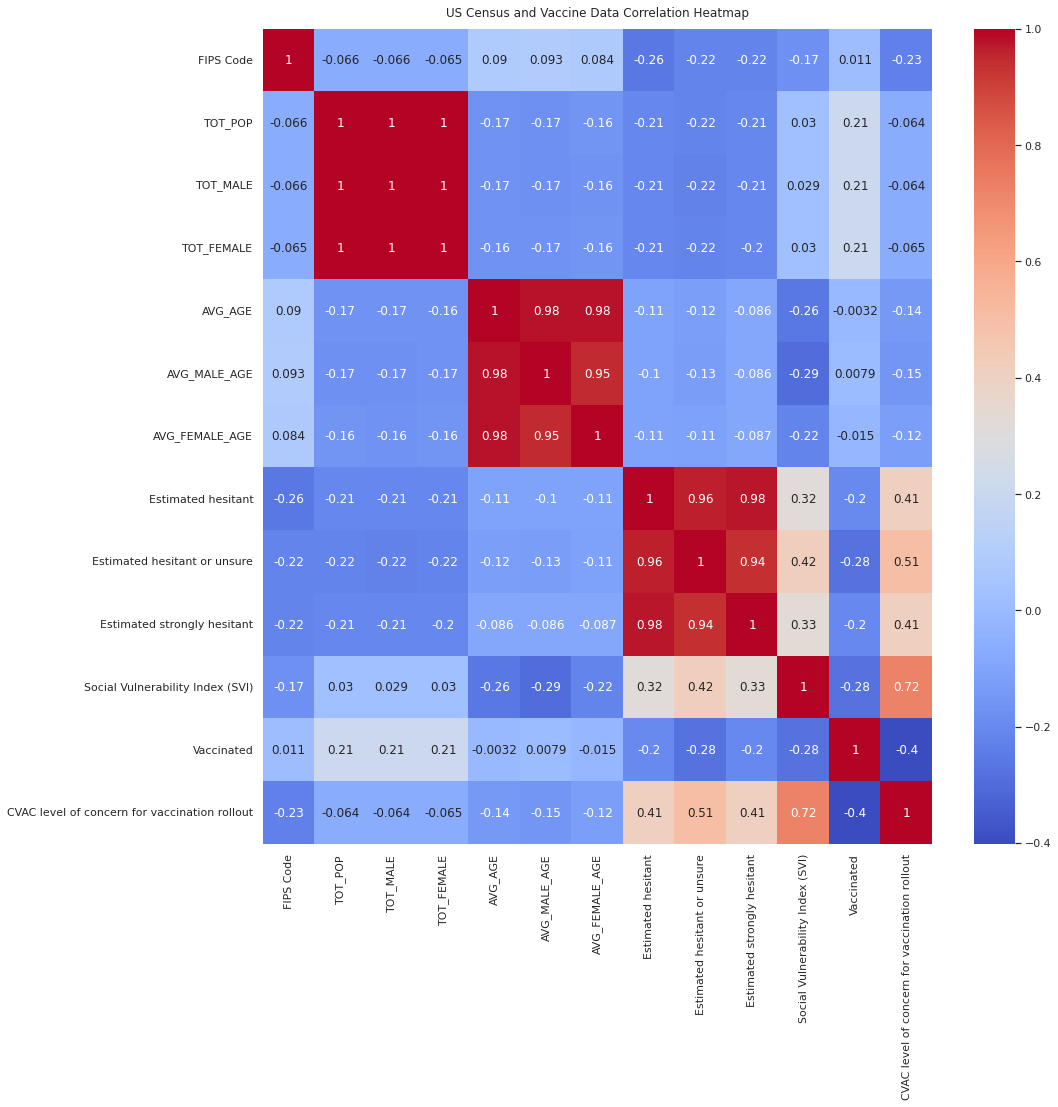

In [ ]:
census_hesitancy_corr = census_hesitancy_df.corr()

plt.figure(figsize = (15, 15))
heatmap = sns.heatmap(census_hesitancy_corr, annot = True, cmap = "coolwarm")
heatmap.set_title("US Census and Vaccine Data Correlation Heatmap", pad=12)

## Heatmap of Correlations among USDA & Vaccine Hesitancy Features



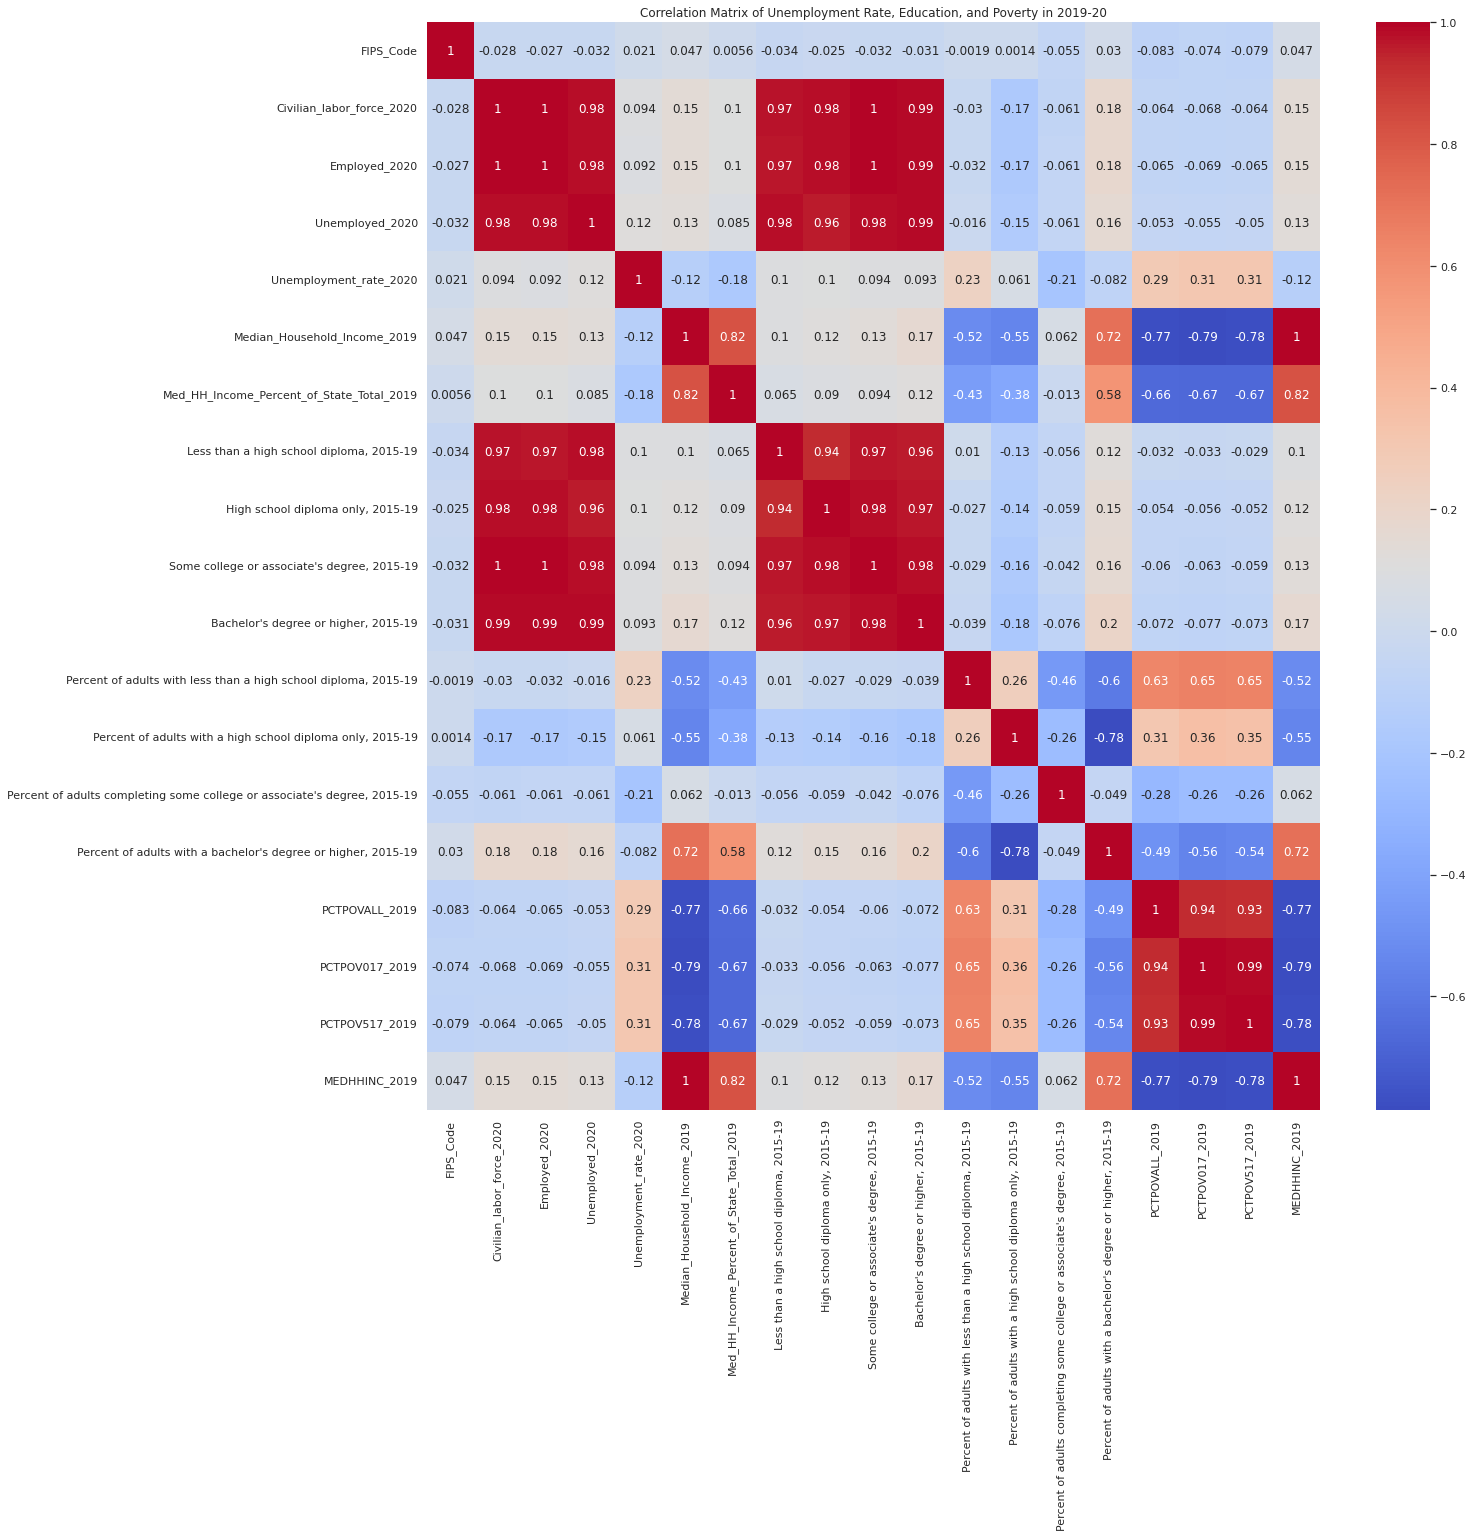

In [ ]:
corr_matrix = usda_data.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.title('Correlation Matrix of Unemployment Rate, Education, and Poverty in 2019-20')
plt.show()

# Model Training & Prediction

## Feature Engineering

### Set Up Data for Hesitancy Prediction ML Classifiers
First we will join together our census, vaccine hesitancy, covid, and usda dataframes to form 1 aggregate dataframe. 

While we do this we can also manually eliminate fields that would cause multicollinearity.

We will then use the Estimated hesitant column as the label that we want to predict.

In [ ]:
# With this query we can manually eliminate the fields in usda_data that would result in multicollinearity 
# through looking at the heatmap of usda_data while also eliminating the fields in census_hesitancy_df 
# that would result in multicollinearity
join_census_hesitancy_usda_query = """SELECT "FIPS CODE",
                TOT_POP, AVG_AGE, "Estimated hesitant", "Social Vulnerability Index (SVI)", 
                "CVAC level of concern for vaccination rollout", Vaccinated,
                Unemployed_2020, Unemployment_rate_2020, Median_Household_Income_2019,
                "Percent of adults with less than a high school diploma, 2015-19",
                "Percent of adults with a high school diploma only, 2015-19",
                "Percent of adults completing some college or associate's degree, 2015-19",
                "Percent of adults with a bachelor's degree or higher, 2015-19"
                FROM census_hesitancy_df AS c
                LEFT JOIN usda_data AS u
                ON c."FIPS CODE" = u.FIPS_Code
                """
census_hesitancy_usda_df = pysqldf(join_census_hesitancy_usda_query)
join_census_hesitancy_usda_covid_query = """SELECT c."FIPS CODE" AS "FIPS CODE",
                TOT_POP, AVG_AGE, "Estimated hesitant", "Social Vulnerability Index (SVI)", 
                "CVAC level of concern for vaccination rollout", Vaccinated,
                Unemployed_2020, Unemployment_rate_2020, Median_Household_Income_2019,
                "Percent of adults with less than a high school diploma, 2015-19",
                "Percent of adults with a high school diploma only, 2015-19",
                "Percent of adults completing some college or associate's degree, 2015-19",
                "Percent of adults with a bachelor's degree or higher, 2015-19",
                Confirmed, Deaths, Incident_Rate, Case_Fatality_Ratio
                FROM census_hesitancy_usda_df AS c
                LEFT JOIN df_jhu_covid_us_date_update AS j
                ON c."FIPS CODE" = j."FIPS CODE"
                """
aggregate_df = pysqldf(join_census_hesitancy_usda_covid_query)
aggregate_df.dropna(how='any', inplace=True)
aggregate_df

,FIPS CODE,TOT_POP,AVG_AGE,Estimated hesitant,Social Vulnerability Index (SVI),CVAC level of concern for vaccination rollout,Vaccinated,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",Confirmed,Deaths,Incident_Rate,Case_Fatality_Ratio
0,45001.0,24527,42,0.1406,0.86,0.81,0.346,670.0,6.6,46499.0,18.349106,34.028507,32.042294,15.580091,2599.0,41.0,10596.485506,1.577530
1,22001.0,62045,38,0.1868,0.92,0.72,0.378,1705.0,7.3,44728.0,21.048416,41.342072,24.315010,13.294503,6729.0,195.0,10845.354178,2.897905
2,51001.0,32316,43,0.0613,0.80,0.50,0.535,1041.0,6.5,47335.0,18.547667,36.725231,25.260561,19.466541,2866.0,44.0,8868.671865,1.535241
3,16001.0,481587,38,0.1771,0.14,0.13,0.547,13893.0,5.4,72295.0,4.839291,22.367348,34.267429,38.525928,53144.0,478.0,11035.181598,0.899443
4,19001.0,7152,42,0.1362,0.05,0.01,0.473,166.0,4.0,57977.0,5.786901,40.547409,35.190617,18.475073,873.0,32.0,12206.375839,3.665521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,6115.0,78668,35,0.0821,0.94,0.79,0.366,3163.0,10.5,56607.0,17.708658,23.594196,41.640121,17.057024,6243.0,50.0,8168.505619,0.778089
2857,2290.0,5230,36,0.2361,0.88,0.93,0.697,280.0,12.1,42063.0,14.032539,40.180126,32.190586,13.596746,368.0,4.0,7036.328872,1.086957
2858,4027.0,213787,38,0.1475,0.99,0.96,0.519,16810.0,17.1,47024.0,26.746960,25.707840,32.519093,15.026110,37266.0,843.0,17431.368605,2.262116
2859,8125.0,10019,38,0.0945,0.56,0.47,0.238,159.0,2.8,52841.0,11.420403,34.381584,32.440567,21.757448,957.0,17.0,9551.851482,1.776385


### Split into Features and Labels

In [ ]:
features = aggregate_df[["TOT_POP",	"AVG_AGE", "Social Vulnerability Index (SVI)",
                         "CVAC level of concern for vaccination rollout",	"Vaccinated",		
                         "Unemployment_rate_2020",	"Median_Household_Income_2019",
                         "Percent of adults with less than a high school diploma, 2015-19",
                         "Percent of adults with a high school diploma only, 2015-19",
                         "Percent of adults completing some college or associate's degree, 2015-19",
                         "Percent of adults with a bachelor's degree or higher, 2015-19",
                         "Confirmed",	"Deaths", "Incident_Rate",	"Case_Fatality_Ratio"]]
labels = aggregate_df[["Estimated hesitant"]]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, train_size = 0.8, random_state = 42)

### PCA Dimensionality Reduction on Vaccine Hesitancy Predicting Features



Text(0, 0.5, 'explained variance')

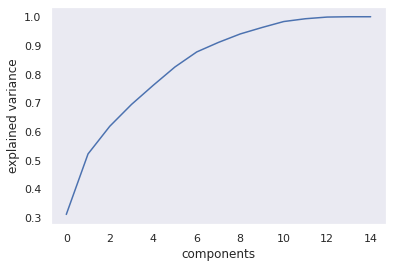

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# scaling
# find num components to use
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

# plot for explained variance
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('components')
plt.ylabel('explained variance')

In [ ]:
pca = PCA(n_components=12)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

## Vaccine Hesitancy Modeling & Predictions

### Bayesian Regression Models

We experiemented Bayesian linear model with L1, L2, and elastic net penalty on our vaccine hesitancy predicting data. We used RMSE as our loss function. 

#### Lasso Regression

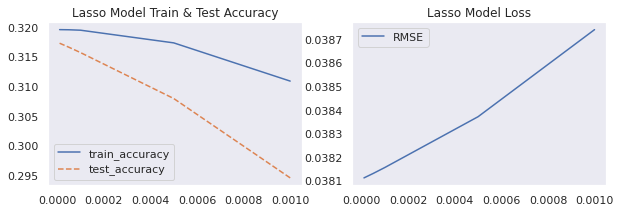

The Lasso Model with alpha=1e-05 yields the best results:
Train R^2 0.31951371256007743, Test R^2 0.31722341171129476, RMSE 0.03811054417254786


Lasso(alpha=1e-05)

In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

def bayesian_model(type, x_train, y_train, x_test, y_test):
  models = []
  train_accuracies = []
  test_accuracies = []
  rmses = []

  alphas = [2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  
  for a in alphas:
    if type == 'Lasso':
      model = Lasso(alpha=a, fit_intercept=True)
    elif type == 'Ridge':
      model = Ridge(alpha=a, fit_intercept=True)
    elif type == 'ElasticNet':
      model = ElasticNet(alpha=a, fit_intercept=True)
    model.fit(x_train, y_train)
    models.append(model)
    y_pred = model.predict(x_test)

    train_accuracies.append(model.score(x_train, y_train))
    test_accuracies.append(model.score(x_test, y_test))
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))

  # plot accuracy
  fig = plt.figure(figsize=(10,3))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)
  ax1.plot(alphas[7:], train_accuracies[7:], label='train_accuracy')
  ax1.plot(alphas[7:], test_accuracies[7:], '--', label='test_accuracy')
  ax1.title.set_text('{} Model Train & Test Accuracy'.format(type))
  ax1.legend()
  
  # plot loss
  ax2.plot(alphas[7:], rmses[7:], label='RMSE')
  ax2.legend()
  ax2.title.set_text('{} Model Loss'.format(type))
  plt.show()

  # index of best result
  i = rmses.index(min(rmses))
  print('The {} Model with alpha={} yields the best results:\nTrain R^2 {}, Test R^2 {}, RMSE {}'.\
        format(type, alphas[i], train_accuracies[i], test_accuracies[i], rmses[i]))
  return models[i];

bayesian_model('Lasso', x_train, y_train, x_test, y_test)


#### Ridge Regression

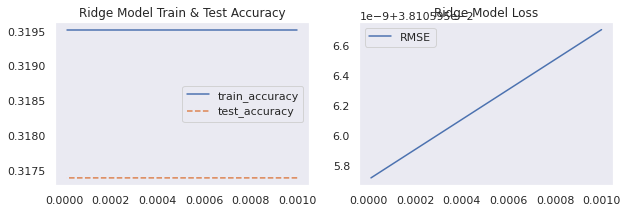

The Ridge Model with alpha=1e-05 yields the best results:
Train R^2 0.3195146836627336, Test R^2 0.31738781246663106, RMSE 0.03810595571744324


Ridge(alpha=1e-05)

In [ ]:
bayesian_model('Ridge', x_train, y_train, x_test, y_test)

#### Elastic Net

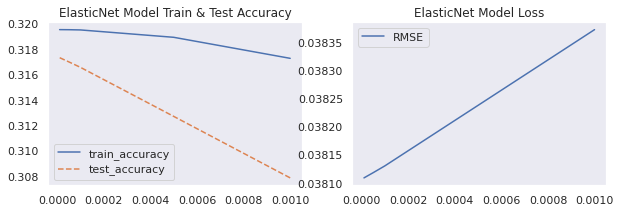

The ElasticNet Model with alpha=1e-05 yields the best results:
Train R^2 0.31951443732528073, Test R^2 0.3173055035075437, RMSE 0.03810825304458225


ElasticNet(alpha=1e-05)

In [ ]:
bayesian_model('ElasticNet', x_train, y_train, x_test, y_test)

### Random Forest Model

To prevent the model from overfitting, we limitted the tree depth with the optimal hyperparamter. 

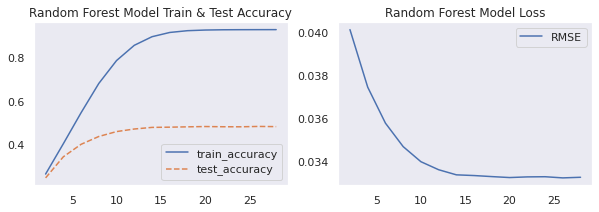

The Random Forest Model with max_depth=26 yields the best results:
Train R^2 0.9269018788111562, Test R^2 0.480623376315216, RMSE 0.03323893030229808


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(x_train, y_train, x_test, y_test):
  models = []
  train_accuracies = []
  test_accuracies = []
  rmses = []

  max_depths = range(2, 30, 2)
  for d in max_depths:
    model = RandomForestRegressor(max_depth=d, n_estimators=500, random_state=42)
    model.fit(x_train, y_train);
    models.append(model)
    y_pred = model.predict(x_test)

    train_accuracies.append(model.score(x_train, y_train))
    test_accuracies.append(model.score(x_test, y_test))
    rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))

  # plot accuracy
  fig = plt.figure(figsize=(10,3))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)
  ax1.plot(max_depths, train_accuracies, label='train_accuracy')
  ax1.plot(max_depths, test_accuracies, '--', label='test_accuracy')
  ax1.title.set_text('Random Forest Model Train & Test Accuracy'.format(type))
  ax1.legend()

  # plot loss
  ax2.plot(max_depths, rmses, label='RMSE')
  ax2.legend()
  ax2.title.set_text('Random Forest Model Loss'.format(type))
  plt.show()

  # index of best result
  i = rmses.index(min(rmses))
  print('The Random Forest Model with max_depth={} yields the best results:\nTrain R^2 {}, Test R^2 {}, RMSE {}'.\
        format(max_depths[i], train_accuracies[i], test_accuracies[i], rmses[i]))
  return models[i];

best_rf = random_forest(x_train, y_train, x_test, y_test)

#### Influential Features Ranking

In [ ]:
# feature importances
importances = list(best_rf.feature_importances_)
feature_list = list(features.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance 
                       in zip(feature_list, importances)]
# sort by importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TOT_POP              Importance: 0.26
Variable: Percent of adults completing some college or associate's degree, 2015-19 Importance: 0.11
Variable: CVAC level of concern for vaccination rollout Importance: 0.09
Variable: Social Vulnerability Index (SVI) Importance: 0.08
Variable: Unemployment_rate_2020 Importance: 0.07
Variable: Percent of adults with a high school diploma only, 2015-19 Importance: 0.07
Variable: AVG_AGE              Importance: 0.06
Variable: Vaccinated           Importance: 0.06
Variable: Percent of adults with a bachelor's degree or higher, 2015-19 Importance: 0.06
Variable: Confirmed            Importance: 0.06
Variable: Median_Household_Income_2019 Importance: 0.05
Variable: Percent of adults with less than a high school diploma, 2015-19 Importance: 0.05


### Neural Network on Vaccine Hesitancy Prediction Data
Our neural network consists of an input layer, two hidden layers, and one output layer with relu activation functions

For our loss function we chose to ues RMSE.



#### Root Mean Squared Error Function

In [ ]:
from tensorflow.keras import backend

def rmse(expected, predicted):
  return backend.sqrt(backend.mean(backend.square(predicted - expected))).numpy()

#### Constructing and Train Neural Network Model

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

data, features = x_train.shape
models, model_rmse, model_history = [], [], []
hidden_neurons, epoch_list = [10, 20, 30], [10, 30, 50, 70]

def createModel(hn, a_function):
  model = Sequential([
      Dense(features, input_dim=features, kernel_initializer='normal', activation=a_function),
      Dense(hn, activation=a_function),
      Dense(hn, activation=a_function),
      Dense(1)
  ])
  model.compile(optimizer="adam",
                loss='mean_squared_error')
  return model

def appendToLists(model, rmse, history):
  models.append(model)
  model_rmse.append(rmse)
  model_history.append(history)

for hn in hidden_neurons:
  for e in epoch_list:
    for a_function in ['relu', 'sigmoid']:
      model = createModel(hn, a_function)
      history = model.fit(x_train, y_train, epochs=e, batch_size=128, verbose=1, validation_split=0.2)
      predictions = model.predict(x_test)
      appendToLists(model, rmse(y_test, predictions), history)

Epoch 1/10
15/15 [==============================] - 1s 18ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/10
15/15 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 1/10
15/15 [

#### Picking the Model with the Best Parameters

In [ ]:
best_rmse = min(model_rmse)
i = model_rmse.index(best_rmse)
model, history = models[i], model_history[i]

Model Summary

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 12)                156       
                                                                 
 dense_57 (Dense)            (None, 20)                260       
                                                                 
 dense_58 (Dense)            (None, 20)                420       
                                                                 
 dense_59 (Dense)            (None, 1)                 21        
                                                                 
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________


#### Neural Network Model Prediction & Performance

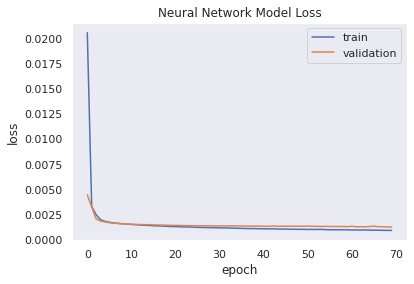

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions

array([[ 0.15532184],
       [ 0.19172868],
       [ 0.16995999],
       [ 0.13033569],
       [ 0.2317616 ],
       [ 0.14149065],
       [ 0.13293958],
       [ 0.18781877],
       [ 0.11722741],
       [ 0.16074282],
       [ 0.13204718],
       [ 0.18006238],
       [ 0.16838121],
       [ 0.14610904],
       [ 0.1315969 ],
       [ 0.15265319],
       [ 0.16420245],
       [ 0.07293069],
       [ 0.22073323],
       [ 0.21215318],
       [ 0.13709804],
       [ 0.1385757 ],
       [ 0.11756682],
       [ 0.07714026],
       [ 0.1918213 ],
       [ 0.17075065],
       [ 0.16802251],
       [ 0.11229588],
       [ 0.05539164],
       [ 0.13041249],
       [ 0.11507224],
       [ 0.20308207],
       [ 0.13824476],
       [ 0.16671333],
       [ 0.10006801],
       [ 0.11367038],
       [ 0.13052998],
       [ 0.15194055],
       [ 0.14961836],
       [ 0.1428775 ],
       [ 0.1577965 ],
       [ 0.10707702],
       [ 0.1497165 ],
       [ 0.113952  ],
       [ 0.11134788],
       [ 0

In [ ]:
# rmse of the predictions
best_rmse

0.034622519492290144

## Best Model for Vaccine Hesitancy Prediction
As the predicting results can vary silightly each time the models are trained, we conclude that both our Random Forest model and Tensorflow based Neural Network model would be the best for predicting Vaccine Hesitancy, since they generates close lowest rmse of all of our models.

## COVID Cases Modeling & Predictions

### Time Series on Covid Cases Prediction Data

In this part, we would utilize the time feature to handle the prediction. And the main method we use is ARIMA.

*   We first groupby the whole data in US to see the whole trend of Confirmed people over time (And found a problem with missing data)
*   We handle the anomalies statistics by imputing and filling the wired gap.
*   We then seek for the suitable parameters associating with p,q,r in ARIMA model and makes prediction. 
*   Finally, we plot the predict data compared with the real data.

In [ ]:
from __future__ import print_function 
import pandas as pd 
import numpy as np 
from scipy import  stats 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from statsmodels.graphics.api import qqplot


####Data preparation

In [ ]:
#Whole time data we had in US
df_jhu_covid_us.rename(columns={'Last_Update':'date'},inplace=True)
df_jhu_covid_us['date']=pd.to_datetime(df_jhu_covid_us['date'])
df_jhu_covid_us['date']=df_jhu_covid_us['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
df_jhu_covid_us['date']=pd.to_datetime(df_jhu_covid_us['date'])
df_jhu_covid_us

,Unnamed: 0,FIPS,Admin2,Province_State,Country_Region,date,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Province/State,Country/Region,Last Update,Incidence_Rate,Case-Fatality_Ratio,Latitude,Longitude,.DS_Store
651,651,1001.0,Autauga,Alabama,US,2021-05-05,32.539527,-86.644082,6910.0,107.0,NaN,NaN,"Autauga, Alabama, US",12368.218511,1.548480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652,652,1003.0,Baldwin,Alabama,US,2021-05-05,30.727750,-87.722071,20993.0,306.0,NaN,NaN,"Baldwin, Alabama, US",9404.033436,1.457629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653,653,1005.0,Barbour,Alabama,US,2021-05-05,31.868263,-85.387129,2302.0,56.0,NaN,NaN,"Barbour, Alabama, US",9325.123552,2.432667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
654,654,1007.0,Bibb,Alabama,US,2021-05-05,32.996421,-87.125115,2597.0,63.0,NaN,NaN,"Bibb, Alabama, US",11596.856301,2.425876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
655,655,1009.0,Blount,Alabama,US,2021-05-05,33.982109,-86.567906,6621.0,135.0,NaN,NaN,"Blount, Alabama, US",11449.866842,2.038967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384669,2384669,56039.0,Teton,Wyoming,US,2021-10-05,43.935225,-110.589080,4953.0,13.0,NaN,NaN,"Teton, Wyoming, US",21108.932833,0.262467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384670,2384670,56041.0,Uinta,Wyoming,US,2021-10-05,41.287818,-110.547578,3578.0,25.0,NaN,NaN,"Uinta, Wyoming, US",17690.101849,0.698714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384671,2384671,90056.0,Unassigned,Wyoming,US,2021-10-05,NaN,NaN,0.0,0.0,NaN,NaN,"Unassigned, Wyoming, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2384672,2384672,56043.0,Washakie,Wyoming,US,2021-10-05,43.904516,-107.680187,1422.0,27.0,NaN,NaN,"Washakie, Wyoming, US",18219.090327,1.898734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#prepare the test data for us to evaluate our model
covid_sum_real=df_jhu_covid_us.groupby(['date']).sum().reset_index()
covid_sum_real.sort_values(by=['date'],inplace=True)
covid_sum_real_c=covid_sum_real['Confirmed']
covid_sum_real_c

0         33969.0
1         43719.0
2         53839.0
3         65976.0
4         83953.0
          ...    
609    47701286.0
610    47730005.0
611    47887585.0
612    47980194.0
613    48091466.0
Name: Confirmed, Length: 614, dtype: float64

#### Plot Sum of Nationwide Confirmed Cases Over Time 

When we plot the whole picture in US, we found some anomalies in our data, inorder to make a more accurate prediction, we choose to fill this abnormous data with the closest neighbor dates' data.

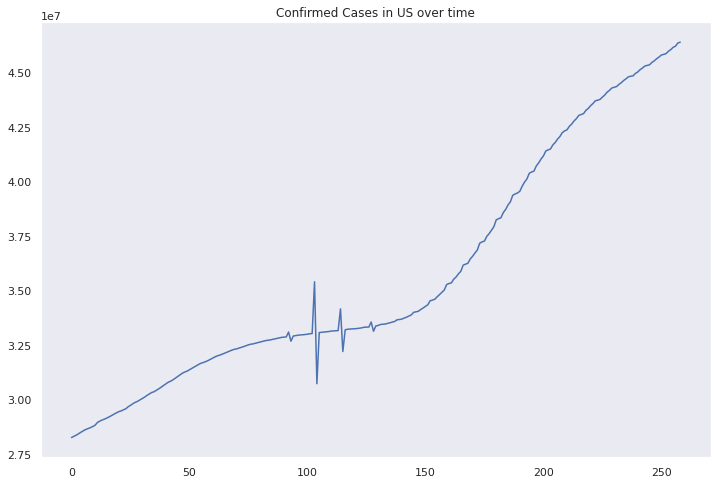

In [ ]:
whole_pic=covid_vaccine_complete.groupby(['date']).sum().reset_index()['Confirmed']
whole_pic.plot(figsize=(12,8))
plt.title('Confirmed Cases in US over time')
plt.show()

We need to fix some abnormal data here

In [ ]:

import datetime
check=covid_vaccine_complete.groupby(['date']).count().reset_index()
missing_date=check[check['Confirmed']<3115]['date'].tolist()

In [ ]:
#prepare the data we need for ARIMA
covid_sum=covid_vaccine_complete.groupby(['date']).sum().reset_index()
covid_sum.sort_values(by=['date'],inplace=True)
covid_sumcop=covid_sum.copy()
for d in missing_date:
  # print(covid_sum[covid_sum['date']==d]['Confirmed'].values[0],covid_sum[covid_sum['date']==(d+datetime.timedelta(days=1))]['Confirmed'].values[0])
  covid_sum.Confirmed[covid_sumcop['date']==d]=covid_sum[covid_sum['date']==(d+datetime.timedelta(days=1))]['Confirmed'].values[0]
  covid_sum.Confirmed[covid_sumcop['date']==d-datetime.timedelta(days=1)]=covid_sum[covid_sum['date']==(d-datetime.timedelta(days=2))]['Confirmed'].values[0]

  #covid_sum['Confirmed']=covid_sum[covid_sum['date']==d]
covid_sum_c=covid_sum['Confirmed']
covid_sum_c

0      28252185.0
1      28305129.0
2      28361057.0
3      28428888.0
4      28495845.0
          ...    
254    46044567.0
255    46145873.0
256    46201068.0
257    46346684.0
258    46383284.0
Name: Confirmed, Length: 259, dtype: float64

After revise these abnormal data, we again plot the whole picture of US Covid Cases situation.

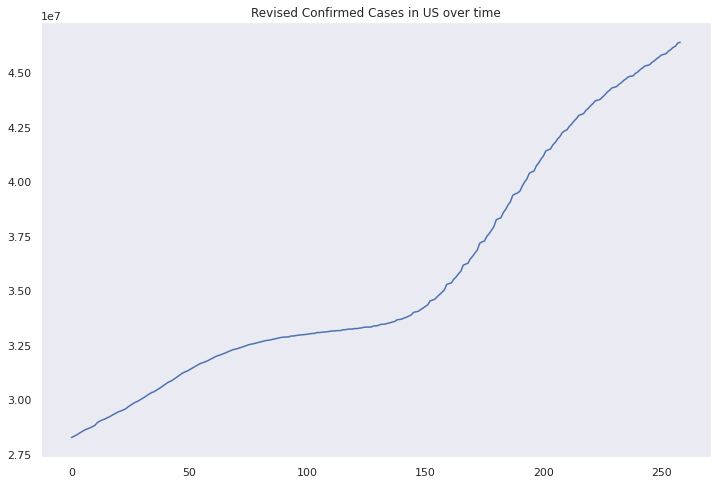

In [ ]:
#This picture shows the Covid Confirmed Cases from 2021-03-15 to 2021-11-15
covid_sum_c.plot(figsize=(12,8))
plt.title('Revised Confirmed Cases in US over time')
plt.show()

####ADF Testing

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def testStationarity(ts):
    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
#ADF test for the data we use
testStationarity(covid_sum_c)

Test Statistic                   0.791588
p-value                          0.991499
#Lags Used                      16.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64

Since that the data is not stable, then we try to use diff_1 to have a more stationary data

In [ ]:
# ts_log = np.log(covid_sum_c)
diff_covid_sum_c = covid_sum_c.diff(1)
diff_covid_sum_c.dropna(inplace=True)
diff_covid_sum_c = diff_covid_sum_c.diff(1)
diff_covid_sum_c.dropna(inplace=True)
testStationarity(diff_covid_sum_c)

Test Statistic                  -2.007793
p-value                          0.283167
#Lags Used                      16.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64

#### ARIMA

For construct ARIMA model, we should first determine the key parameters such as p,q,d

In [ ]:
#find the value for p,q
pMax = int(covid_sum_c.shape[0]/10)# pmax is less than length/10
qMax = pMax# the same as p
bics = list()
for p in range(pMax + 1):
    tmp = list()
    for q in range(qMax + 1):
        try:
            tmp.append(arima_model.ARIMA(covid_sum_c, (p, 1, q)).fit().bic)
        except Exception as e:
            tmp.append(1e+10)

    bics.append(tmp)
bics = pd.DataFrame(bics)
p, q = bics.stack().idxmin()
print(p,q)

0 0


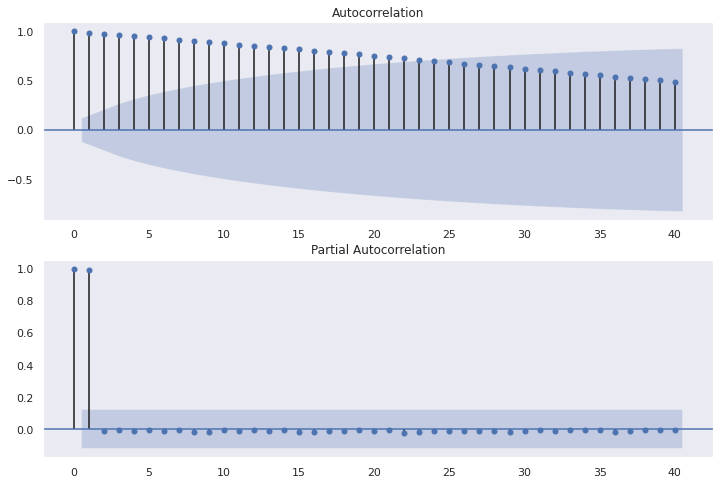

In [ ]:
#print out the pic Autocorrelation and partial Autocorrelation
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(covid_sum_c,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(covid_sum_c,lags=40,ax=ax2)

Now, after deciding the parameters for arima, we can do our prediction job!

[46453559.57751938 46523835.15503876 46594110.73255814 46664386.31007752
 46734661.8875969  46804937.46511628 46875213.04263566 46945488.62015504
 47015764.19767442 47086039.7751938 ]


Text(0.5, 1.0, 'ARIMA')

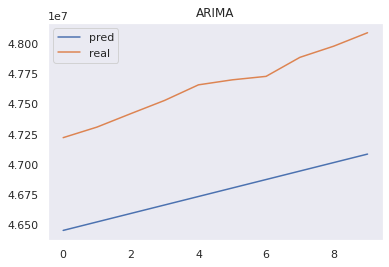

In [ ]:
#predict US's Confirmed Cases from 2021-11-15 to 2021-11-25
import datetime
start_date = pd.to_datetime('2021-11-15')
end_date = pd.to_datetime('2021-11-30')
real=covid_sum_real[(covid_sum_real['date']>start_date)&(covid_sum_real['date']<=end_date)]['Confirmed'].tolist()
from statsmodels.tsa import arima_model
model = arima_model.ARIMA(covid_sum_c,order=(p, 1, q)).fit()
predict = model.forecast(10)[0]
print(predict)
plt.rcParams['axes.unicode_minus']=False
plt.plot(range(10),predict,label="pred")
plt.plot(range(10),real,label="real")
plt.legend()
plt.title('ARIMA')


### Linear Regression on Covid Cases Prediction Data

In [ ]:
#To view the whole columns we use as the feature
covid_vaccine_complete.columns

Index(['FIPS Code', 'County_Name', 'Province_State', 'Latitude', 'Longitude',
       'date', 'Confirmed', 'Deaths', 'Combined_Key', 'Incident_Rate',
       'Case_Fatality_Ratio', 'County Name', 'State',
       'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)',
       'Estimated hesitant', 'Estimated hesitant or unsure',
       'Estimated strongly hesitant', 'Social Vulnerability Index (SVI)',
       'SVI Category', 'CVAC level of concern for vaccination rollout',
       'CVAC Level Of Concern'],
      dtype='object')

In [ ]:
#To sort data with the County and also the date
covid_vaccine_complete=covid_vaccine_complete.sort_values(by=['FIPS Code','date'])

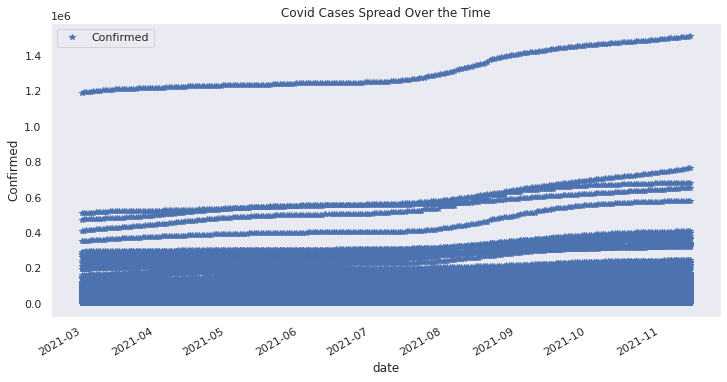

In [ ]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# col is the feature that we used for prediction
col=['FIPS Code', 'Latitude', 'Longitude',
       'date', 'Deaths', 'Incident_Rate',
       'Case_Fatality_Ratio', 
       'Percent adults fully vaccinated against COVID-19 (as of 6/10/21)',
       'Estimated hesitant', 'Estimated hesitant or unsure',
       'Estimated strongly hesitant', 'Social Vulnerability Index (SVI)',
       'CVAC level of concern for vaccination rollout',
       'Confirmed']#, 'County_Name', 'Province_State','County Name', 'State','Combined_Key','SVI Category','CVAC Level Of Concern'

 
data=covid_vaccine_complete[col].copy()
data['date'] = pd.to_datetime(data['date'])
#plt.figure(figsize=(12, 6))
data.plot(x = 'date', y = 'Confirmed', style = '*',figsize=(12, 6))

plt.title('Covid Cases Spread Over the Time')
plt.xlabel('date')
plt.ylabel('Confirmed')
plt.show()


[0.05186494 0.58048256 0.84342393 0.84284159 0.82896463 0.83469707
 0.83680392 0.84013814 0.84164582]


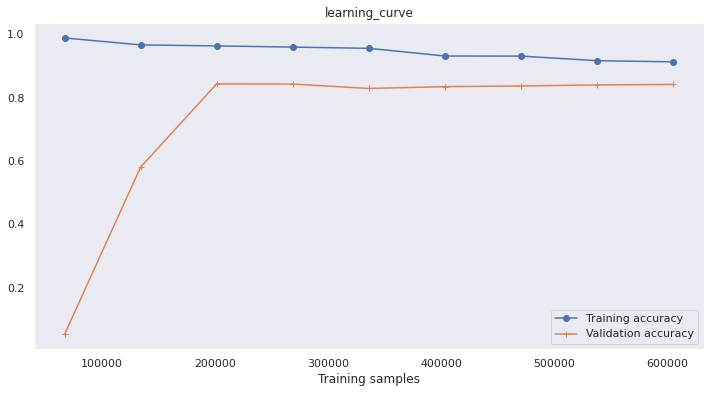

In [ ]:
#learning curve to analyze a reasonable data split rate
from sklearn.model_selection import learning_curve
data['date']=data['date'].map(dt.datetime.toordinal)
clf =  LinearRegression()  

train_sizes, train_scores, test_scores = \
  learning_curve(estimator=clf,
                 X=data[col[:-1]],
                 y=data[col[-1]],
                 train_sizes=[0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8, 0.9],
                 cv=6,
                 n_jobs=1)
#print(train_sizes)
print(np.mean(test_scores, axis=1))
plt.figure(figsize=(12, 6))
plt.plot(train_sizes,np.mean(train_scores, axis=1),\
 marker='o', label='Training accuracy')
plt.plot(train_sizes,np.mean(test_scores, axis=1),\
 marker='+', label='Validation accuracy')
plt.xlabel('Training samples')
plt.title('learning_curve')
plt.legend()



We could see that it performs rather well

In [ ]:
#data['date']=data['date'].map(dt.datetime.toordinal)
X=data[col]
y=data[['date','FIPS Code','Confirmed']]#.values.reshape(-1,1)
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=.2,random_state=0)


In [ ]:
#Los_Y=Y_test[Y_test['FIPS Code']==36061.0	]
Y_test_c=Y_test.copy()
Y_test_index=Y_test_c.reset_index().reset_index()
Y_test_index.rename(columns={'index':'index_1'},inplace=True)
Y_test_index.rename(columns={'level_0':'index'},inplace=True)
Los_Y=Y_test_index[Y_test_index['FIPS Code']==6037.0]
Los_Y

,index,index_1,date,FIPS Code,Confirmed
1673,1673,52665,737925,6037,1237021.0
6367,6367,52619,737953,6037,1245949.0
12644,12644,52674,737942,6037,1244054.0
16762,16762,52646,737965,6037,1248161.0
17153,17153,52727,738058,6037,1451438.0
19495,19495,52782,737944,6037,1244275.0
20155,20155,52677,738097,6037,1495014.0
21046,21046,52747,737877,6037,1217775.0
27129,27129,52649,737984,6037,1258685.0
29784,29784,52654,737907,6037,1231838.0


#### Dimensionality Reduction Using PCA on Covid Cases Prediction Data


Before Linear regression part:

Use Principal component analysis to reduce number of dimensions of the dataset, as a first step fit a pca model on train set and then plot the explained_variance_ratio against the number of components to decide the number of components we should keep.

In [ ]:
# scaling
# find num components to use
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train=X_train[col[:-1]]
x_test=X_test[col[:-1]]
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

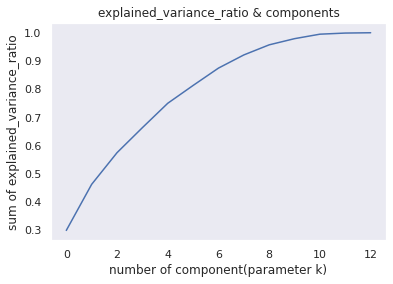

In [ ]:
#sklearn.PCA.explained_variance_ration：
# We should ideally set k(k principal eigenvectors) to the smallest value where we see things flatten out

pca = PCA(n_components =x_train_std.shape[1])##

pca.fit(x_train_std)
pca.explained_variance_ratio_

###Diagram for picking a suitable parameter k for the PCA：
plt.title('explained_variance_ratio & components')
plt.xlabel('number of component(parameter k)')
plt.ylabel('sum of explained_variance_ratio')
plt.plot([i for i in range(x_train_std.shape[1])],
        [np.sum(pca.explained_variance_ratio_[:i+1]) for i in range(x_train_std.shape[1])])
plt.show()


In [ ]:

# scaling first
# Use PCA model
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train=X_train[col[:-1]]
x_test=X_test[col[:-1]]
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

n_components = 10
#components = pca.fit_transform(df[features])
pca = PCA(n_components=n_components)
components = pca.fit_transform(x_train_std)
#fcol=['scored_by','popularity', 'members' , 'favorites','genre_labels','studio_labels','source_labels','title_labels']

In [ ]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.29879764 0.16347445 0.1122516  0.08875776 0.08652208 0.06323372
 0.06156663 0.0466921  0.03582132 0.02190505]


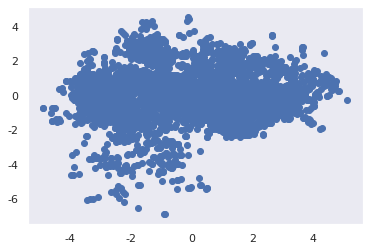

In [ ]:
#plot the pic of PCA scatter point
pca_plot = PCA(n_components=10)
comp = pca_plot.fit_transform(x_train_std)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

In [ ]:
#Transform data after train a PCA model
#then use Linear regression for data prediction

x_test_trans = pca.transform(x_test_std)
x_train_trans=pca.transform(x_train_std)
y_train=Y_train[col[-1]]
y_test=Y_test[col[-1]]


#### Implement Linear Regression after PCA

In [ ]:
#Linear regression part
reg = LinearRegression()  
reg.fit(x_train_trans,y_train)
y_pre_pca = reg.predict(x_test_trans)
y_pre_pca

array([ -1368.90983494,   3123.57940999,  22574.78839683, ...,
         3930.09150539, -10658.92341951,  65729.12130695])

evaluation part for LR(w/o  regularization)

In this part, we not only show the final score of our model,  but also do we visualize an example of the prediction performance of a county.

In [ ]:
print("Coefficient of determination: %f"%  reg.score(x_test_trans, Y_test[col[-1]]))
print("mean_square_error:%.4f"% mean_squared_error(y_test, y_pre_pca))

Coefficient of determination: 0.913750
mean_square_error:137064010.3746


In [ ]:
#Los_Y=Y_test[Y_test['FIPS Code']==36061.0	]
Y_test_c=Y_test.copy()
Y_test_index=Y_test_c.reset_index().reset_index()
Y_test_index.rename(columns={'index':'index_1'},inplace=True)
Y_test_index.rename(columns={'level_0':'index'},inplace=True)
Los_Y=Y_test_index[Y_test_index['FIPS Code']==6037.0]
Los_Y

,index,index_1,date,FIPS Code,Confirmed
1673,1673,52665,737925,6037,1237021.0
6367,6367,52619,737953,6037,1245949.0
12644,12644,52674,737942,6037,1244054.0
16762,16762,52646,737965,6037,1248161.0
17153,17153,52727,738058,6037,1451438.0
19495,19495,52782,737944,6037,1244275.0
20155,20155,52677,738097,6037,1495014.0
21046,21046,52747,737877,6037,1217775.0
27129,27129,52649,737984,6037,1258685.0
29784,29784,52654,737907,6037,1231838.0


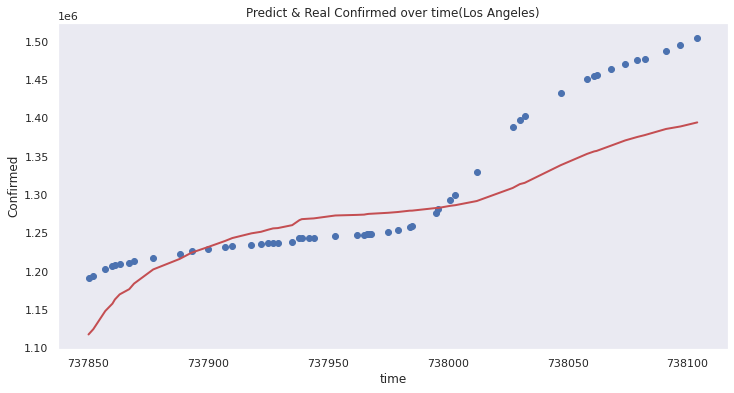

In [ ]:
y_pre_pca = pd.DataFrame(y_pre_pca).reset_index()
test_index=pd.merge(Los_Y,y_pre_pca,how='left',on='index')
test_index=test_index.sort_values(by=['date'])
# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(test_index['date'], test_index['Confirmed'], 'o')           # scatter plot showing actual data
plt.plot(test_index['date'], test_index[0], 'r', linewidth=2)   # regression line
plt.xlabel('time')
plt.ylabel('Confirmed')
plt.title('Predict & Real Confirmed over time(Los Angeles)')
plt.show()

#### Lasso Model

**Lasso loss function:**
 $\frac{1}{2n_{samples}}\cdot ||y-x_w||_{2}^{2} + \alpha ||w||_1$

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
LassoCV = linear_model.LassoCV(alphas = [2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5],cv=3)
y_pred_lassocv = LassoCV.fit(x_train_std, y_train).predict(x_test_std)
r2_score_lassocv = r2_score(Y_test[col[-1]], y_pred_lassocv)


evaluation part for LR(with L1 regularization)

In [ ]:
print(LassoCV)
print("mean_square_error:%.2f"%mean_squared_error(y_test,y_pred_lassocv))
print('Coefficient of determination: %f' % r2_score_lassocv)
print('best value for alpha',LassoCV.alpha_) 

LassoCV(alphas=[2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05,
                1e-05],
        cv=3)
mean_square_error:136285609.05
Coefficient of determination: 0.914240
best value for alpha 1e-05


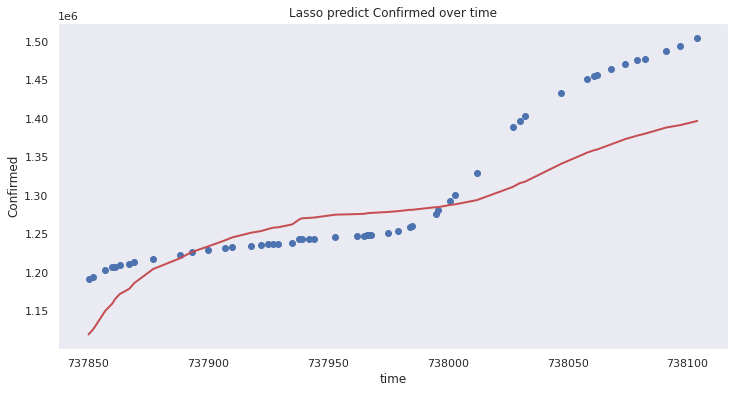

In [ ]:
y_pred_lasso = pd.DataFrame(y_pred_lassocv).reset_index()
test_index=pd.merge(Los_Y,y_pred_lasso,how='left',on='index')
test_index=test_index.sort_values(by=['date'])
# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(test_index['date'], test_index['Confirmed'], 'o')           # scatter plot showing actual data
plt.plot(test_index['date'], test_index[0], 'r', linewidth=2)   # regression line
plt.xlabel('time')
plt.ylabel('Confirmed')
plt.title('Lasso predict Confirmed over time')
plt.show()

#### Ridge Model

**Ridge loss function:**
 $\frac{1}{2n_{samples}}\cdot ||y-x_w||_{2}^{2} + \alpha ||w||_2$

Adding crossvalidation to select the best alpha for model:

In [ ]:
from sklearn import linear_model
RidgeCV=linear_model.RidgeCV(alphas = [2, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5],fit_intercept=True)
RidgeCV.fit(x_train_std, y_train)
y_predict_CVRidge=RidgeCV.predict(x_test_std)

evaluation part for LR(with L2 regularization)

In [ ]:

print("mean_square_error:%.2f"%mean_squared_error(Y_test[col[-1]], y_predict_CVRidge))
print('Coefficient of determination: %f'
      % r2_score(Y_test[col[-1]], y_predict_CVRidge))
print('best value for alpha',RidgeCV.alpha_) 


mean_square_error:136285607.58
Coefficient of determination: 0.914240
best value for alpha 0.1


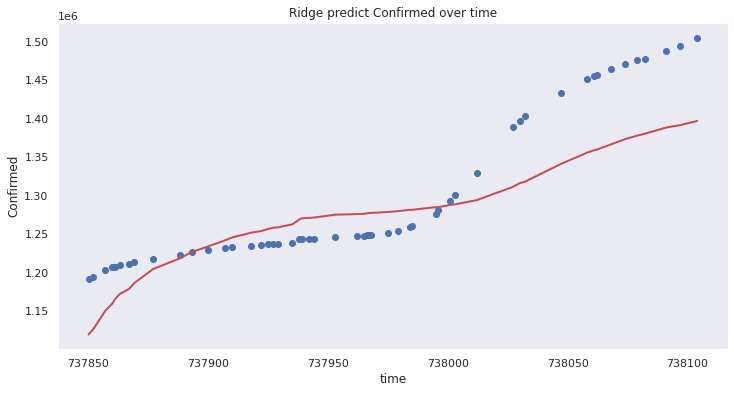

In [ ]:
y_predict_Ridge = pd.DataFrame(y_predict_CVRidge).reset_index()
test_index=pd.merge(Los_Y,y_predict_Ridge,how='left',on='index')
test_index=test_index.sort_values(by=['date'])
# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(test_index['date'], test_index['Confirmed'], 'o')           # scatter plot showing actual data
plt.plot(test_index['date'], test_index[0], 'r', linewidth=2)   # regression line
plt.xlabel('time')
plt.ylabel('Confirmed')
plt.title('Ridge predict Confirmed over time')
plt.show()

#### ElasticNet Model




**ElasticNet loss function:**
 $\frac{1}{2n_{samples}}\cdot ||y-x_w||_{2}^{2} + l1_{ratio} \alpha ||w||_1 + (1-l1_{ratio}) \alpha ||w||^2_2$


In [ ]:
elastic_model = linear_model.ElasticNetCV(alphas = [2, 1, 0.5, 0.1, 0.05, 0.02,0.01, 0.005, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5],fit_intercept=True,l1_ratio=0.5)

#RidgeCV=linear_model.RidgeCV(alphas=[0.1,0.3,0.5,0.7,1],fit_intercept=True)
elastic_model.fit(x_train_std, y_train)
y_predict_elastic=elastic_model.predict(x_test_std)

In [ ]:

print("mean_square_error:%.2f"%mean_squared_error(Y_test[col[-1]], y_predict_elastic))
print('Coefficient of determination: %f'
      % r2_score(Y_test[col[-1]], y_predict_elastic))
print('best value for alpha',elastic_model.alpha_) 

mean_square_error:136285563.35
Coefficient of determination: 0.914240
best value for alpha 1e-05


best value for alpha:0.0030391953823131978
Coefficient of determination: 0.914240
mean_square_error:136277957.74


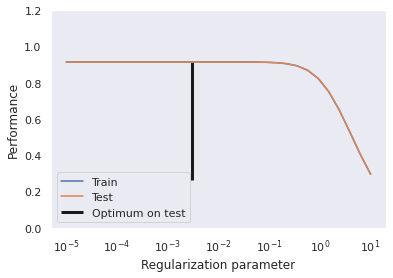

In [ ]:
# Compute train and test errors
alphas = np.logspace(-5, 1, 30)
enet = linear_model.ElasticNet(l1_ratio=0.5)
train_errors = list()
test_errors = list()
mse_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(x_train_std, y_train)
    train_errors.append(enet.score(x_train_std, y_train))
    test_errors.append(enet.score(x_test_std, y_test))
    mse_errors.append(mean_squared_error(Y_test[col[-1]], enet.predict(x_test_std)))
 
i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
mse_errors_=mse_errors[i_alpha_optim]
print("best value for alpha:%s" % alpha_optim)
alpha_optim
print('Coefficient of determination: %f'
      % r2_score(Y_test[col[-1]], y_predict_elastic))
print("mean_square_error:%.2f"%mse_errors_)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_
 
# Plot results functions
 
import matplotlib.pyplot as plt
# plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')
plt.show()

#### Model Results & Selection 

Compared the r2-score and MSE in different models, we finally found that ElasticNet performed the best.